In [1]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

<module 'galaxy_survey' from '/home/yanlong/Dropbox/galaxy_survey/galaxy_survey.cpython-38-x86_64-linux-gnu.so'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['axes.xmargin'] = 0

## Debug camb_cosmology

In [3]:
cm = gc.camb_cosmology()

In [4]:
cm.rstar

97.30929571942731

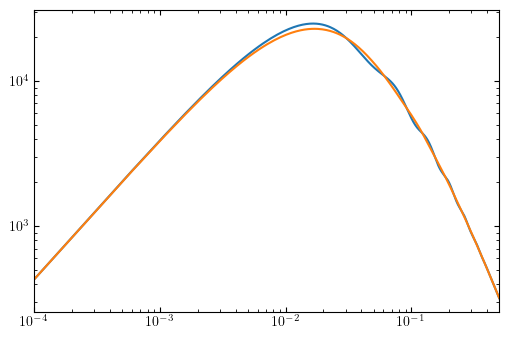

In [5]:
kh = np.linspace(0.0001, .5, num=1000)
plt.loglog(kh, [cm.matter_power_spectrum(x) for x in kh])
plt.loglog(kh, [cm.matter_power_spectrum_no_wiggle(x) for x in kh])

<ipython-input-6-815fc7d2d594>:5: UserWarning: Class did not read input parameter(s): Omega_m
  engine = CLASS.ClassEngine({'H0':70, 'Omega_m':0.31})
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


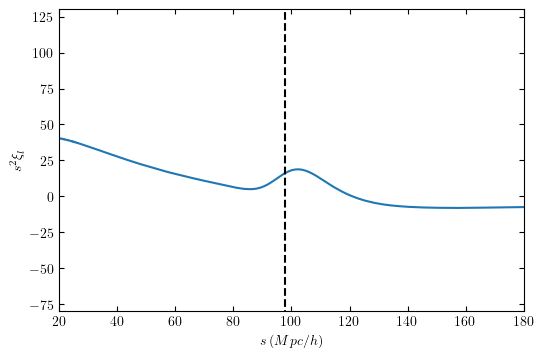

In [6]:
import hankl
import classylss
import classylss.binding as CLASS

engine = CLASS.ClassEngine({'H0':70, 'Omega_m':0.31})
bg = CLASS.Background(engine)
cosmo = CLASS.ClassEngine({'output': 'dTk vTk mPk', 'non linear': 'halofit', 'P_k_max_h/Mpc' : 20., "z_max_pk" : 100.0})
sp = CLASS.Spectra(cosmo)
tm = CLASS.Thermo(cosmo)

k = np.logspace(-4, 1, 2**10)
pk = sp.get_pklin(k=k, z=0.)

s, xi = hankl.P2xi(k, pk, l=0)

plt.plot(s, xi*s**2)
plt.xlim(20,180)
plt.plot([tm.rs_rec, tm.rs_rec], [-100, 300], 'k--')
plt.ylim(-80,130)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{l}$')
plt.show()

/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, 

Text(0.5, 0, '$r\\,[h^{-1}{\\rm Mpc}]$')

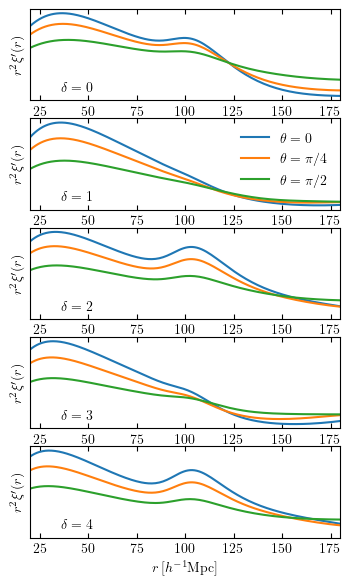

In [7]:
def bis(k1, delta, theta):
    k1, k2, k3 = gs.k_tf(k1, delta*np.pi/tm.rs_rec, theta)
    p1, p2, p3 = sp.get_pklin(k1, 0), sp.get_pklin(k2, 0), sp.get_pklin(k3, 0)
    c1, c2, c3 = gs.cost(k1, k2, k3), gs.cost(k2, k3, k1), gs.cost(k3, k1, k2)
    f1, f2, f3 = gs.f_kernal(k1, k2, c1), gs.f_kernal(k2, k3, c2), gs.f_kernal(k3, k1, c3)
    return 2*(f1*p1*p2+f2*p2*p3+f3*p3*p1)

k = np.logspace(-4, 1, 2**10)

fig, axs = plt.subplots(5, 1, figsize=(4, 7))

for d in [0, 1, 2, 3, 4]:
    ax = axs[d]
    for t, lb in zip(np.array([0, .25, .5])*np.pi, [r'$\theta=0$', r'$\theta=\pi/4$', r'$\theta=\pi/2$']):
        b = [bis(x, d, t) for x in k]
        s, xi = hankl.P2xi(k, b, l=0)
        ax.plot(s, xi*s**2, label=lb)
    ax.set_xlim(20,180)
    ax.annotate(r'$\delta=%d$'%d, (0.1, 0.1), xycoords='axes fraction', ha='left')
#plt.ylim(10,1000)
axs[1].legend(ncol=1, frameon=False)
for ax in axs:
    ax.set_yticks([])
    ax.set_ylabel(r"$r^2\xi'(r)$")
axs[-1].set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$')

In [7]:
anu = 7/8 *(4/11)**(4/3)
anu = 1/anu
def set_omch2(nnu, ombh2, omch2):
    return (anu+nnu)/(anu+3.046)*(ombh2+omch2)-ombh2

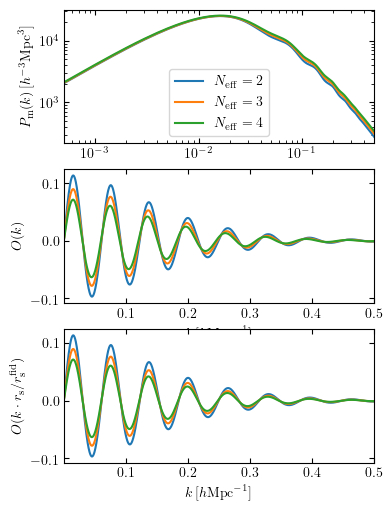

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(4, 6))

kh = np.linspace(0.0005, .5, num=1000)

p = {'nnu':{'value':3},
     'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0008},
     'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.001},}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3

for nnu in [2, 3, 4]:
    p['nnu']['value'] = nnu
    p['omch2']['value'] = set_omch2(nnu, p0['ombh2']['value'], p0['omch2']['value'])
    cm = gc.camb_cosmology(p, p0)
    alpha = cm.alpha
    axs[0].loglog(kh, [cm.matter_power_spectrum(x) for x in kh], label=r'$N_{\rm eff}=%.0f$'%nnu)
    axs[0].set_ylabel(r'$P_{\rm m}(k)\,[h^{-3}{\rm Mpc}^3]$')
    axs[0].legend()
    
    axs[1].plot(kh, [cm.oscillation_part(x) for x in kh])
    axs[1].set_ylabel(r'$O(k)$')
    axs[1].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
    
    axs[2].plot(kh, [cm.oscillation_part(x*alpha) for x in kh])
    axs[2].set_ylabel(r'$O(k\cdot r_{\rm s}/r_{\rm s}^{\rm fid})$')
    axs[2].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
    
plt.savefig('neutrino_effect_ps.pdf', bbox_inches='tight')

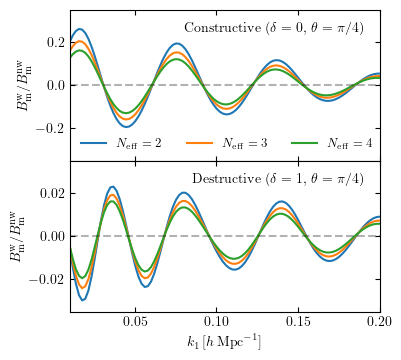

In [10]:
p = {'nnu':{'value':3},
     'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0008},
     'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.001},}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
matplotlib.rcParams['xtick.top'] = True


fig, axs = plt.subplots(2, 1, figsize=(4, 4))
ks = np.linspace(0.01, 0.2, num=100)
for nnu in [2, 3, 4]:
    p['nnu']['value'] = nnu
    p['omch2']['value'] = set_omch2(nnu, p0['ombh2']['value'], p0['omch2']['value'])
    svy = gs.survey(p, p0, prepare_derivatives=False)
    alpha = svy.camb_cosmology.alpha
    svy.update_survey_setups()
    for i in range(2):
        ax = axs[i]
        bs = [svy.bispectrum((x*alpha, svy.pisf*i, np.pi/4), matter_only=True, coordinate='child18', damp=False)\
          /svy.bispectrum((x*alpha, svy.pisf*i, np.pi/4), matter_only=True, coordinate='child18', damp=False, no_wiggle=True)-1.\
          for x in ks]
        if i==0:
            label = r'$N_{\rm eff}=%d$'%nnu
        else:
            label = None
        ax.plot(ks, bs, label = label)
        if i==0:
            ax.legend(frameon=False, ncol=3, prop={'size': 9},)
        ax.set_ylabel(r'$B^{\rm w}_{\rm m}/B^{\rm nw}_{\rm m}$')
        ax.set_xlim(ks.min(), ks.max())
        
        if nnu==3:
            os = [svy.camb_cosmology.oscillation_part(x)+svy.camb_cosmology.oscillation_part(x+svy.pisf*i) for x in ks]
            if i==1:
                2333
                #ax.plot(ks, os, c='k', ls=':', label=r'$O(k_1)+O(k_1+\delta\pi/r_{\rm s})$')
                #ax.legend(frameon=False, loc='upper right')
            else:
                2333
                #ax.plot(ks, os, c='k', ls=':')
        
axs[0].annotate(r'Constructive ($\delta=0,\, \theta=\pi/4$)', (0.95, 0.85), xycoords='axes fraction', ha='right')
axs[1].annotate(r'Destructive ($\delta=1,\, \theta=\pi/4$)', (0.95, 0.85), xycoords='axes fraction', ha='right')
axs[1].set_xlabel(r'$k_1\,[h\,{\rm Mpc}^{-1}]$')
axs[0].set_xticklabels([])

for ax in axs:
    ax.plot([0.01, 0.2], [0, 0], 'k--', alpha=.3)

axs[0].set_ylim(-0.35, 0.35)
axs[1].set_ylim(-0.035, 0.035)

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('plots/nnu-bispectrum-interference.pdf', bbox_inches='tight')
plt.show()

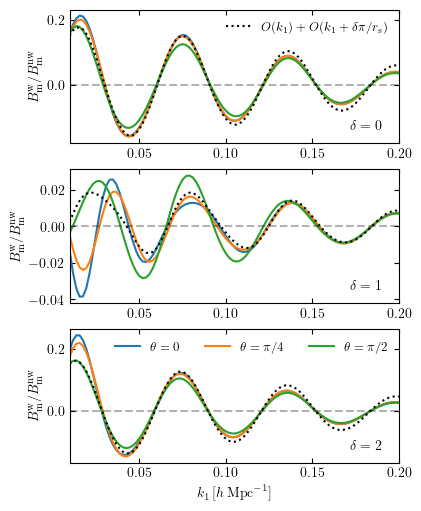

In [11]:
p = {'nnu':{'value':3},
     'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0008},
     'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.001},}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
matplotlib.rcParams['ytick.right'] = True


fig, axs = plt.subplots(3, 1, figsize=(4.25, 6))
ks = np.linspace(0.01, 0.2, num=100)
for nnu in [3.046]:
    p['nnu']['value'] = nnu
    p['omch2']['value'] = set_omch2(nnu, p0['ombh2']['value'], p0['omch2']['value'])
    svy = gs.survey(p, p0, prepare_derivatives=False)
    svy.update_survey_setups()
    for i in range(3):
        for theta, lb in zip([0.001, 0.25*np.pi, 0.5*np.pi], [r'$\theta=0$', r'$\theta=\pi/4$', r'$\theta=\pi/2$']):
            ax = axs[i]
            bs = [svy.bispectrum((x, svy.pisf*i, theta), matter_only=True, coordinate='child18', damp=False)\
              /svy.bispectrum((x, svy.pisf*i, theta), matter_only=True, coordinate='child18', damp=False, no_wiggle=True)-1.\
              for x in ks]
            if i==2:
                ax.plot(ks, bs, label=lb)
            else:
                ax.plot(ks, bs)
        os = [svy.camb_cosmology.oscillation_part(x)+svy.camb_cosmology.oscillation_part(x+svy.pisf*i) for x in ks]
        if i==0:
            ax.plot(ks, os, c='k', ls=':', label=r'$O(k_1)+O(k_1+\delta\pi/r_{\rm s})$')
        else:
            ax.plot(ks, os, c='k', ls=':')
        ax.annotate(r'$\delta=%d$'%i, (0.95, 0.1), xycoords='axes fraction', ha='right')

for ax in axs:
    ax.plot([0.01, 0.2], [0, 0], 'k--', alpha=.3)
    ax.set_ylabel(r'$B^{\rm w}_{\rm m}/B_{\rm m}^{\rm nw}$')
axs[-1].set_xlabel(r'$k_1\,[h\,{\rm Mpc}^{-1}]$')
axs[0].legend(frameon=False, prop={'size': 9})
axs[-1].legend(frameon=False, ncol=3, prop={'size': 9},)

plt.savefig('plots/bispectrum-wiggles.pdf', bbox_inches='tight')

plt.show()

0 0.001
0 0.7853981633974483
0 1.5707963267948966
1 0.001
1 0.7853981633974483
1 1.5707963267948966
2 0.001
2 0.7853981633974483
2 1.5707963267948966


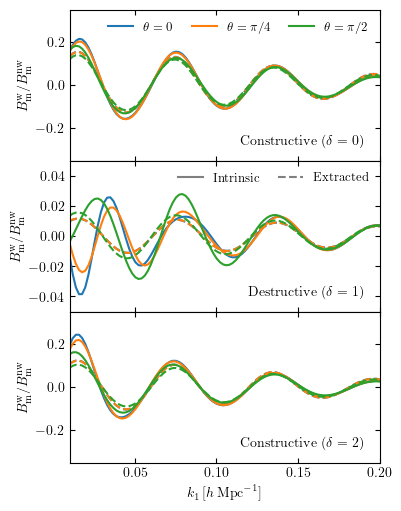

In [15]:
import dewiggle as dw
pk = cm.camb.get_matter_power_interpolator(nonlinear=False).P

def bis(k1, delta, theta):
    k1, k2, k3 = gs.k_tf(k1, delta*np.pi/tm.rs_rec, theta)
    p1, p2, p3 = pk(0, k1), pk(0, k2), pk(0, k3)
    c1, c2, c3 = gs.cost(k1, k2, k3), gs.cost(k2, k3, k1), gs.cost(k3, k1, k2)
    f1, f2, f3 = gs.f_kernal(k1, k2, c1), gs.f_kernal(k2, k3, c2), gs.f_kernal(k3, k1, c3)
    return 2*(f1*p1*p2+f2*p2*p3+f3*p3*p1)


p = {'nnu':{'value':3},
     'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0008},
     'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.001},}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
matplotlib.rcParams['ytick.right'] = True


fig, axs = plt.subplots(3, 1, figsize=(4, 6))
ks = np.linspace(0.01, 0.2, num=100)
for nnu in [3.046]:
    p['nnu']['value'] = nnu
    p['omch2']['value'] = set_omch2(nnu, p0['ombh2']['value'], p0['omch2']['value'])
    svy = gs.survey(p, p0, prepare_derivatives=False)
    svy.update_survey_setups()
    
    for i in range(3):
        for theta, lb in zip([0.001, np.pi/4, np.pi/2], [r'$\theta=0$', r'$\theta=\pi/4$', r'$\theta=\pi/2$']):
            ax = axs[i]
            bs = [svy.bispectrum((x, svy.pisf*i, theta), matter_only=True, coordinate='child18', damp=False)\
              /svy.bispectrum((x, svy.pisf*i, theta), matter_only=True, coordinate='child18', damp=False, no_wiggle=True)-1.\
              for x in ks]
            
            if i==0:
                pl = ax.plot(ks, bs, label=lb)
            else:
                pl = ax.plot(ks, bs)
                
            kks = np.logspace(-4, 0.5, num=20000)
            bbs = np.array([bis(x, i, theta) for x in kks])
            print(i, theta)
            b, bnw = dw.dewiggle(kks, bbs)
            ax.plot(ks, [b(x)/bnw(x)-1 for x in ks], ls='--', c=pl[0].get_color())
        
        if i%2==0:
            cf = 'Constructive'
        else:
            cf = 'Destructive'
        ax.annotate(r'%s ($\delta=%d$)'%(cf, i), (0.95, 0.1), xycoords='axes fraction', ha='right')

for ax in axs:
    #ax.plot([0.01, 0.2], [0, 0], 'k--', alpha=.3)
    ax.set_ylabel(r'$B^{\rm w}_{\rm m}/B_{\rm m}^{\rm nw}$')
for i in range(2):
    axs[i].set_xticklabels([])
axs[-1].set_xlabel(r'$k_1\,[h\,{\rm Mpc}^{-1}]$')
#axs[0].legend(frameon=False, prop={'size': 9})
axs[0].legend(frameon=False, ncol=3, prop={'size': 9}, columnspacing=1.5)

plt.subplots_adjust(wspace=0, hspace=0)
axs[0].set_ylim(-0.35, 0.35)
axs[1].set_ylim(-0.05, 0.05)
axs[2].set_ylim(-0.35, 0.35)

axs[1].plot([.1, .11], [-2, -1], c='grey', label='Intrinsic')
axs[1].plot([.1, .11], [-2, -1], c='grey', ls='--', label='Extracted')
axs[1].legend(frameon=False, ncol=2, loc='upper right', prop={'size': 9}, columnspacing=1.5)

plt.savefig('plots/bispectrum-bao-extraction.pdf', bbox_inches='tight')
plt.show()

In [4]:
%timeit cm.matter_power_spectrum_no_wiggle(0.5)

95.6 ns ± 0.938 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [5]:
%timeit cm.matter_power_spectrum(0.5)

93.4 ns ± 0.22 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [6]:
cm.matter_power_spectrum.cache_info()

CacheInfo(hits=81111110, misses=1000001, maxsize=None, currsize=1000001)

In [7]:
%timeit cm.oscillation_part(0.5)

95 ns ± 0.33 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [8]:
%timeit cm.q_isotropic(0.5)

93.1 ns ± 0.151 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


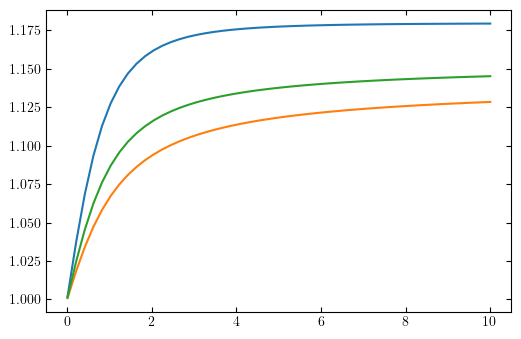

In [43]:
p['nnu']['value'] = 4
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
cm = gc.camb_cosmology(p, p0)
for q in cm.get_ap_factors():
    zs = np.linspace(0.01, 10)
    plt.plot(zs, [q(x) for x in zs])

In [31]:
pp = cm.power_spectrum_derivative_parts_factory({'nnu':{'value':2}}, {'nnu':{'value':4}}, 1)

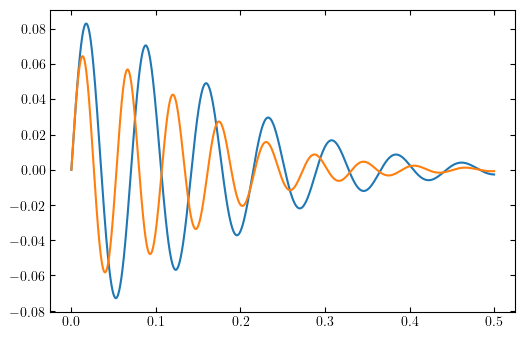

In [32]:
kh = np.linspace(0.0001, .5, num=1000)
for key in ['plus', 'minus']:
    plt.plot(kh, [pp[key]['oscillation_part'](x) for x in kh])

In [18]:
cm.prepare_power_spectrum_derivative_parts(['ombh2', 'nnu'])

In [20]:
cm.power_spectrum_derivative_parts

{'ombh2': {'plus': {'matter_power_spectrum': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'matter_power_spectrum_no_wiggle': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'oscillation_part': <function galaxy_correlations.camb_cosmology.get_power_spectrum.<locals>.<lambda>(x)>,
   'q_parallel': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_vertical': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_isotropic': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>},
  'minus': {'matter_power_spectrum': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'matter_power_spectrum_no_wiggle': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'oscillation_part': <function galaxy_correlations.camb_cosmology.get_power_spectrum.<locals>.<lambda>(x)>,
   'q_parallel': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_vertical':

## Debug galaxy_survey PS

In [1]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)
import fisher_matrix as fm
reload(fm)

<module 'fisher_matrix' from 'C:\\Users\\yanlo\\Dropbox\\galaxy_survey\\fisher_matrix.py'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [3]:
cp = {'nnu':{'value':3.046}}
fcp = {'nnu':{'value':3.046}}

In [7]:
#svy = gs.survey(cosmological_parameters=cp, fiducial_cosmological_parameters=fcp)
svy = gs.survey()
svy.update_survey_setups()

[[-6.58099546e+00  6.15705909e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -9.27994231e-02 -4.49926456e+02 -1.22493407e-01]
 [-6.03060993e+00  5.63864987e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -8.50695526e-02 -4.20274987e+02 -1.12182538e-01]
 [-5.51233046e+00  5.15050112e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.77906564e-02 -3.92353821e+02 -1.02473340e-01]
 [-5.03220375e+00  4.69830533e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.10476838e-02 -3.66488692e+02 -9.34791247e-02]
 [-4.59288383e+00  4.28455935e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -6.48779214e-02 -3.42822522e+02 -8.52496203e-02]
 [-4.19449085e+00  3.90937359e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.92830564e-02 -3.21361699e+02 -7.77870676e-02]
 [-3.83543558e+00  3.57124872e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.42407598e-02 -3.02020517e+02 -7.10616716e-02]
 [-3.51310152e+00  3.26771830e+00  0.00000000e+00  0.00000000e+00
   

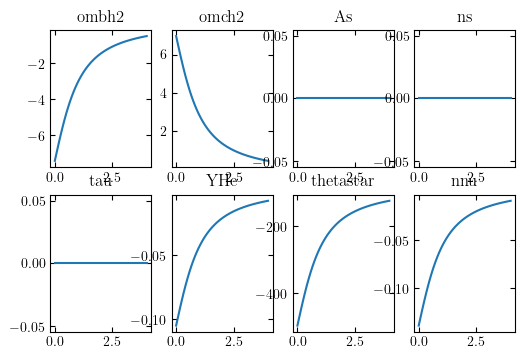

In [6]:
zs = np.linspace(0, 4)

fig, axs = plt.subplots(2, 4)
for key, i in zip(svy.cosmological_parameters_in_fisher, range(8)):
    ax = axs[i//4, i%4]
    dadp = [svy.camb_cosmology.d_alpha_d_parameter(x, key) for x in zs]
    ax.plot(zs, dadp)
    ax.set_title(key)
    
svy.prepare_alpha_transfer_matrix(alpha_redshift_dependence=True)
print(svy.alpha_transfer_matrix)
print(svy.alpha_transfer_matrix_entries)

In [61]:
svy0 = gs.survey(cosmological_parameters=cp, fiducial_cosmological_parameters=fcp, cosmological_parameters_in_fisher=[])
svy0.update_survey_setups()

In [6]:
%timeit svy.integrand_bs((.1,.1,.1,0,0),0)
#%timeit svy.integrand_ps(0.4, 0, 0)

1.27 ms ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


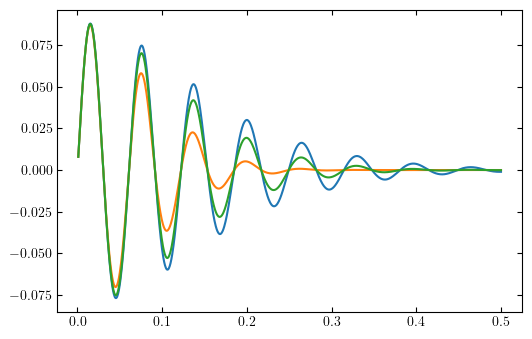

In [7]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy.oscillation_part(x, damp=False) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, damp=True) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, damp=True, reconstruction=True) for x in kh])

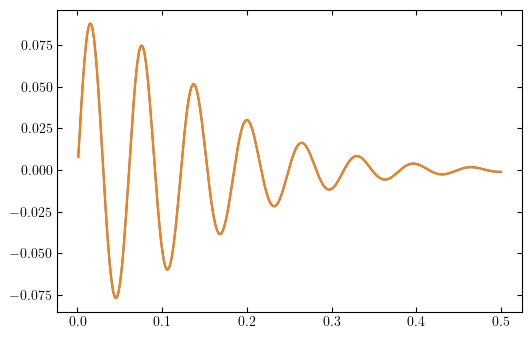

In [8]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy0.oscillation_part(x) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, fix_rstar=True, ap_effect=False) for x in kh])

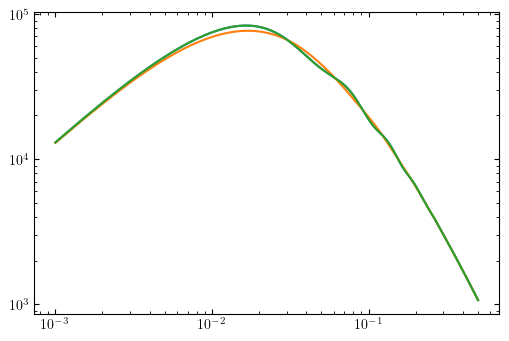

In [9]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 1
plt.loglog(kh, [svy.power_spectrum(x, mu, z) for x in kh])
plt.loglog(kh, [svy.power_spectrum(x, mu, z, no_wiggle=True) for x in kh])
plt.loglog(kh, [svy.power_spectrum(x, mu, z, debug=True, rsd=True, bias=True, noise=True, damp=True, ap_effect=True, reconstruction=True) for x in kh])

2.1476862055383164

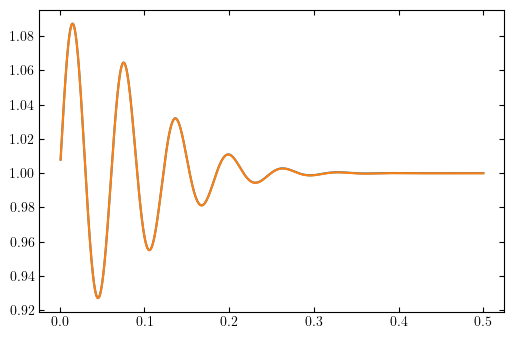

In [10]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 0
plt.plot(kh, [svy.power_spectrum(x, mu, z)/svy.power_spectrum(x, mu, z, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.power_spectrum(x, mu, z, matter_only=True, external_ps_parts=(lambda x: 1.0, svy.camb_cosmology.oscillation_part, 
            svy.camb_cosmology.q_parallel, svy.camb_cosmology.q_vertical, svy.camb_cosmology.q_isotropic)) for x in kh])

svy.rsd_factor_z1(z, mu, rsd=True, bias=True)**2

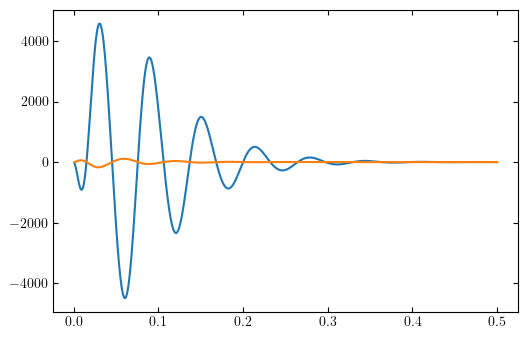

In [11]:
kh = np.linspace(0.001, .5, num=1000)
dos = np.array([svy.power_spectrum_derivative_analytical(x) for x in kh])
plt.plot(kh, dos[:,0])
plt.plot(kh, dos[:,1])

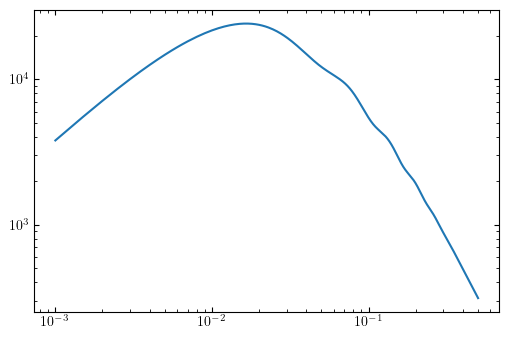

In [12]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.power_spectrum_derivative_bias(x)[0] for x in kh])
plt.loglog(kh, dps)

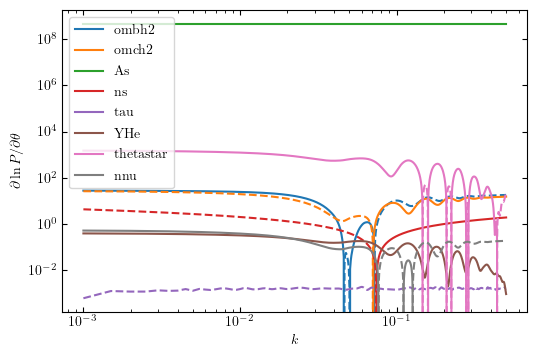

In [13]:
kh = np.linspace(0.001, .5, num=1000)
z=0
dps = np.array([np.array(svy.power_spectrum_derivative_cosmological_parameters(x, z=z))/svy.power_spectrum(x, z=z) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.loglog(kh, dps[:,i], label=l)
    plt.loglog(kh, -dps[:,i], c=pl[0].get_color(), ls='--')
    
plt.ylabel(r'$\partial \ln P/\partial \theta$')
plt.xlabel('$k$')
plt.legend()

0.19403084266200743

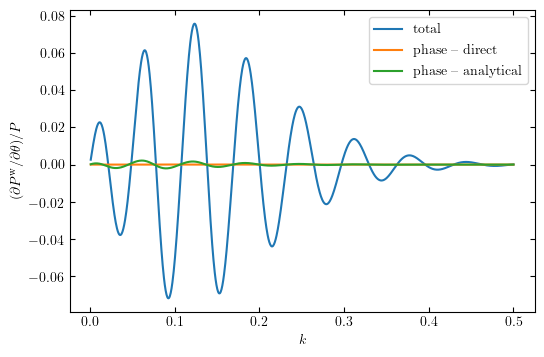

In [73]:
kh = np.linspace(0.001, .5, num=1000)
z=2
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=True)\
                /svy.power_spectrum(x, z=z, no_wiggle=True) for x in kh])

pl = plt.plot(kh, dps[:,-1], label='total')
    
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=False, phase_only=True)\
                /svy.power_spectrum(x, z=z, no_wiggle=True) for x in kh])

pl = plt.plot(kh, dps[:,-1], label='phase -- direct')


dps = np.array([svy.power_spectrum_derivative_analytical(x)\
                /svy.power_spectrum(x, z=z, no_wiggle=True) for x in kh])

dbdn = (df.n2b(3.047)-df.n2b(3.046))/0.001
pl = plt.plot(kh, dps[:,-1]*dbdn, label='phase -- analytical')

plt.ylabel(r'$(\partial P^{\rm w}/\partial \theta)/P$')
plt.xlabel('$k$')
plt.legend()
dbdn

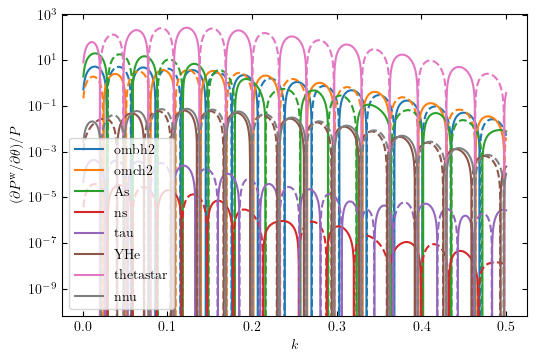

In [15]:
kh = np.linspace(0.001, .5, num=1000)
z=0
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=True)/svy.power_spectrum(x, z=z) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, dps[:,i], label=l)
    plt.plot(kh, -dps[:,i], c=pl[0].get_color(), ls='--')

plt.ylabel(r'$(\partial P^{\rm w}/\partial \theta)/P$')
plt.xlabel('$k$')
plt.legend()

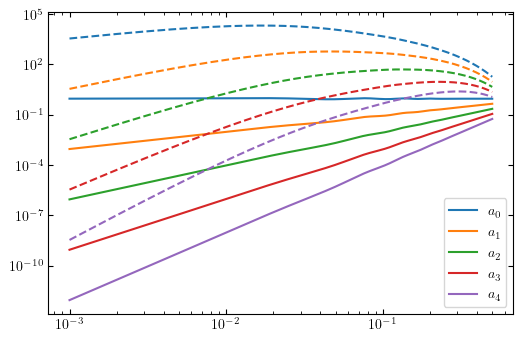

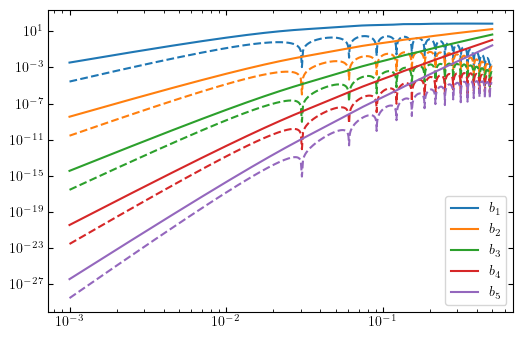

In [16]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.power_spectrum_derivative_polynomial(x) for x in kh])
dpws = np.array([svy.power_spectrum_derivative_polynomial(x, wiggle_only=True) for x in kh])
a = svy.polynomial_parameters['a']
b = svy.polynomial_parameters['b']
for i, l in zip(range(len(a)), a):
    pl = plt.loglog(kh, dps[:,i], label='$a_{%d}$'%l)
    plt.loglog(kh, dpws[:,i], ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

for i, l in zip(range(len(a), len(a)+len(b)), b):
    pl = plt.loglog(kh, dps[:,i], label='$b_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

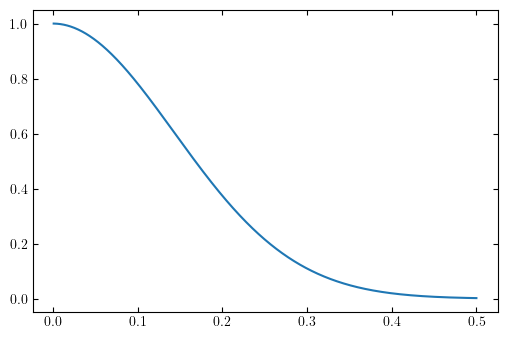

In [17]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 2
dps = np.array([svy.power_spectrum(x, mu, z, no_wiggle=False, matter_only=False) for x in kh])
dpnws = np.array([svy.power_spectrum(x, mu, z, no_wiggle=True, matter_only=False) for x in kh])
damps = np.array([svy.damping_factor(x, mu, z, damp=True, reconstruction=True) for x in kh])
plt.plot(kh, damps)

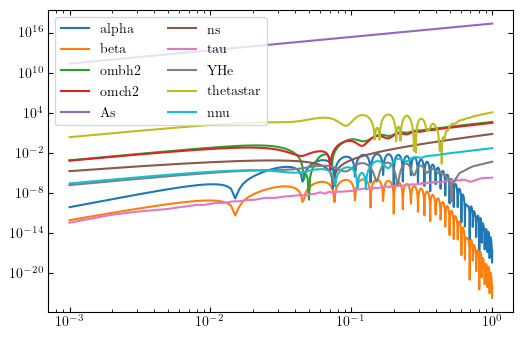

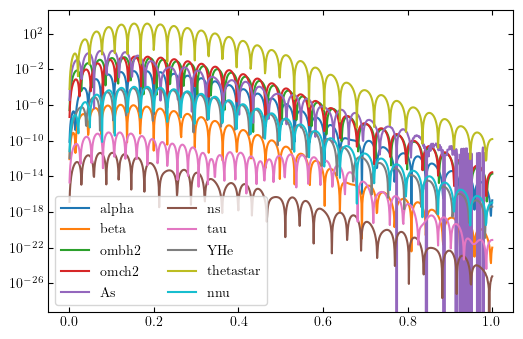

In [18]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0, wiggle_only=True)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

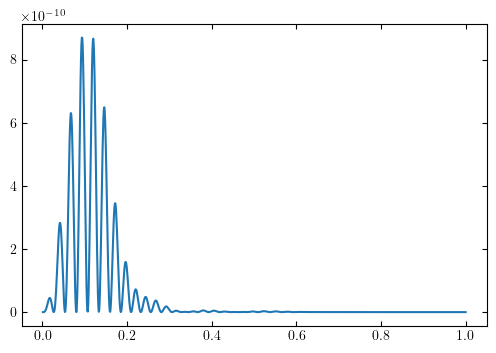

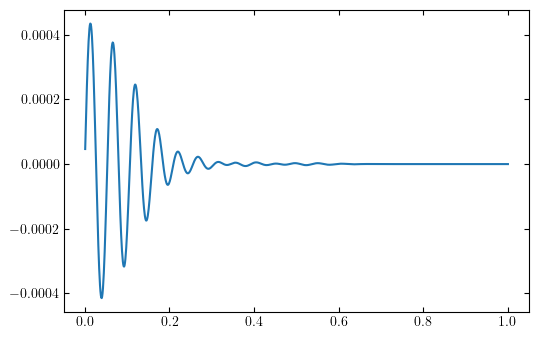

In [34]:
kh = np.linspace(0.001, 1, num=1000)
i = 6
dp = [svy.integrand_ps(x, 0, 0, wiggle_only=True)[i, i] for x in kh]
pl = plt.plot(kh, dp)
plt.show()

kh = np.linspace(0.001, 1, num=1000)
z = 0
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, z=z, wiggle_only=True)/svy.power_spectrum(x, z=z) for x in kh])
pl = plt.plot(kh, dps[:,i-2], label=l)

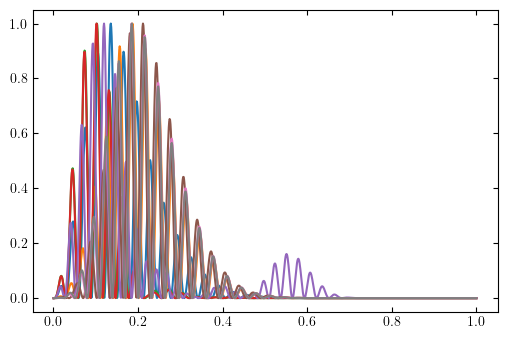

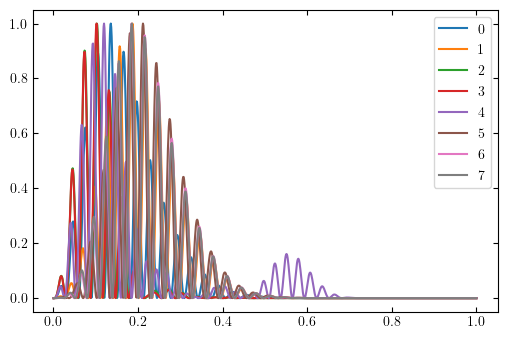

In [32]:
kh = np.linspace(0.001, 1, num=1000)
svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fisher', 'polynomial_in_fisher', 'ap_effect', 'shot_noise', 'reconstruction'])

mu, z = 0, 1

for i in range(2, 10):
    dp = np.array([svy.integrand_ps(x, mu, z, wiggle_only=True)[i, i] for x in kh])
    pl = plt.plot(kh, dp/dp.max())
plt.show()

for j in range(8):
    dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, mu, z, wiggle_only=True) for x in kh])
    ps = np.array([svy.power_spectrum(x, mu, z) for x in kh])
    ts = dps[:,j]**2/ps**2*kh**2
    plt.plot(kh, ts/ts.max(), label='%d'%j)
plt.legend()
plt.show()

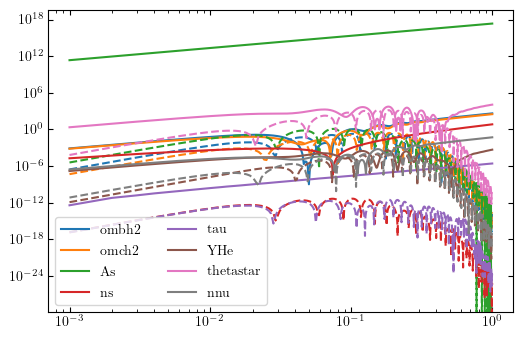

In [20]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(2, 10), svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
    dp = [svy.integrand_ps(x, 0, 0, wiggle_only=True)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, ls='--', c=pl[0].get_color())    
plt.legend(ncol=2)
plt.show()

In [21]:
for x in [False, True]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    print(fs.constraints()[1]['nnu'], fs.constraints()[1]['beta'])

0.4661712183339122 0.1790021648484712
11.658901557228004 0.39468065778827627


In [22]:
for x in [False, True]:
    svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fishe', 'polynomial_in_fishe', 'ap_effect', 'shot_noise', 'reconstruction'])
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    print(fs.constraints()[1]['nnu'], fs.constraints()[1]['beta'])

0.2680052713589669 0.13684260754913788
3.5390286235215127 0.23771712563501715


In [72]:
def sb2sn(x):
    return 1/0.194057*x
def sn2sb(y):
    return 0.194057*y

In [17]:
import h5py
for x in [False, True]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    with h5py.File('planck_cmb_fisher.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sb = fs.slice(['nnu', 'thetastar'], exclude=True).merge(cmb_fisher).constraints()[1]['beta']
    print(sb, sb2sn(sb))

0.009954393127613077 0.05129623320783624
0.01664502210572712 0.08577388141487872


In [18]:
for x in [False, True]:
    svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fisher', 'polynomial_in_fisher', 'ap_effect', 'shot_noise', 'reconstruction'])
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x).slice(['alpha', 'beta'], exclude=True)
    fs.matrix = fs.matrix
    with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sn = fs.merge(cmb_fisher).slice(['YHe'], exclude=True).constraints()[1]['nnu']
    print(sn)

0.014871077266374596
0.03451123372070868


In [63]:
ndesi = np.loadtxt('desi-density.txt')
ndesi[:,1]/=1e3
sky_deg = 4*np.pi*(180/np.pi)**2
desi_geo = {
    'f_sky': 14000/sky_deg,
    'ng_z_list': ndesi,
    'dz': 0.1,
    'Sigma_0': 16.6,
    'b_0': 0.95,
    'survey_type':'spectroscopic',
    'sigma8_0': 0.9,
}

In [64]:
svy.update_survey_setups(desi_geo, polynomial_parameters={'a': [], 'b': [1, ]})

In [50]:
for x in [True, False]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, regions=[{'k_min': 0.01,'k_max': 0.5,'mu_min': -1.0,'mu_max': 1.0}])
    fs = fs.slice(['alpha', 'beta'], exclude=True)
    with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sn = fs.merge(cmb_fisher).slice(['YHe'], exclude=True).constraints()[1]['nnu']
    print(sn)

0.09576190122613
0.03967311168932633


In [35]:
import h5py
import defaults as df

dfs = df.defaults()
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid,]
#surveys = [dfs.boss, dfs.desi]

with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)

ks = np.linspace(0.011, 0.3, num=41)

with h5py.File("ps_kamx_dependence.hdf5", "w") as f:
    f.create_dataset('kmaxs', data=ks)
    for survey in surveys:
        key_svy = survey['short_name']
        print(key_svy)
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
        else:
            group_svy = f[key_svy]
        
        sns = []
        for k in tqdm(ks):
            temp = []
            for x in [False, True]:
                if x:
                    pp = {'a': [0,1,2,3,4], 'b' :[1,2,3]}
                else:
                    pp = {'a': [], 'b' :[1]}
                svy.update_survey_setups(survey_geometrics=survey, polynomial_parameters=pp,
                                        ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fisher', 'polynomial_in_fisher', 'ap_effect', 'shot_noise'],
                                        )
                fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, 
                                                          div_k = int(max((k-0.01)//0.005, 2)),
                                                          div_mu = 20,
                                                          regions=[{'k_min': 0.01,'k_max': k,'mu_min': -1.0,'mu_max': 1.0}])
                fs = fs.slice(['poly', 'bias'], fuzzy_filter=True, exclude=True)
                sn = fs.merge(cmb_fisher).slice(['YHe', 'alpha', 'beta'], exclude=True).constraints()[1]['nnu']
                temp.append(sn)
                sn = fs.merge(cmb_fisher).slice(['alpha', 'beta'], exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        group_svy.create_dataset('sns', data=sns)

boss


  0%|          | 0/41 [00:00<?, ?it/s]

desi


  0%|          | 0/41 [00:00<?, ?it/s]

spherex


  0%|          | 0/41 [00:00<?, ?it/s]

pfs


  0%|          | 0/41 [00:00<?, ?it/s]

roman


  0%|          | 0/41 [00:00<?, ?it/s]

euclid


  0%|          | 0/41 [00:00<?, ?it/s]

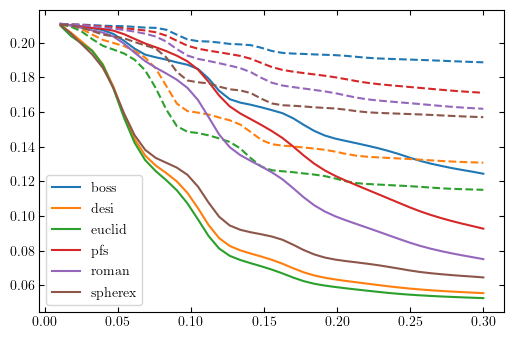

In [36]:
with h5py.File("ps_kamx_dependence.hdf5", 'r') as f:
    kmaxs = f['kmaxs']
    for svy_key in f.keys():
        if svy_key == 'cvl' or svy_key =='kmaxs':
            continue
        sns = f[svy_key]['sns'][()]
        #print(sns)
        pl = plt.plot(kmaxs, sns[:,0], label=svy_key)
        plt.plot(kmaxs, sns[:,2], ls='--', c=pl[0].get_color())
    plt.legend()
    plt.show()

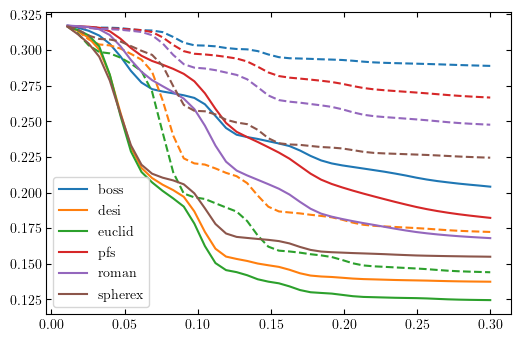

In [37]:
with h5py.File("ps_kamx_dependence.hdf5", 'r') as f:
    kmaxs = f['kmaxs']
    for svy_key in f.keys():
        if svy_key == 'kmaxs' or svy_key == 'cvl':
            continue
        sns = f[svy_key]['sns'][()]
        pl = plt.plot(kmaxs, sns[:,1], label=svy_key)
        plt.plot(kmaxs, sns[:,3], ls='--', c=pl[0].get_color())
    plt.legend()
    plt.show()

## Debug galaxy_survey BS

In [4]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

import fisher_matrix as fm

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [5]:
svy = gs.survey()

In [4]:
svy.update_survey_setups()

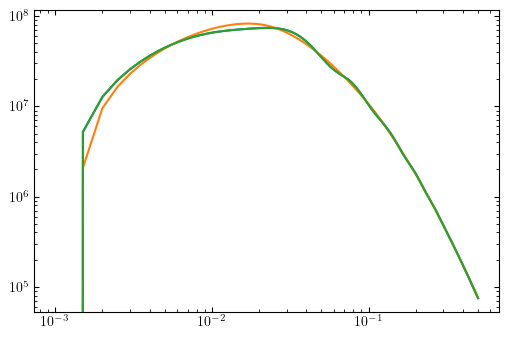

In [5]:
kh = np.linspace(0.001, .5, num=1000)
plt.loglog(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18') for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', reconstruction=True) for x in kh])

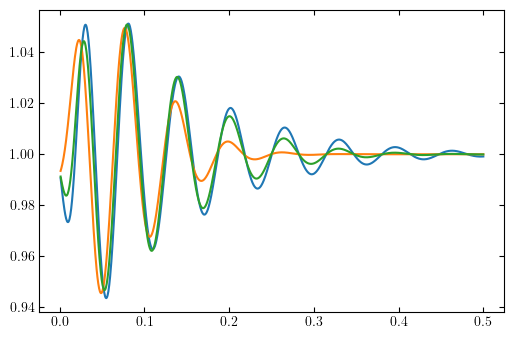

In [6]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, damp=True, reconstruction=False)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, damp=True, reconstruction=True)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])

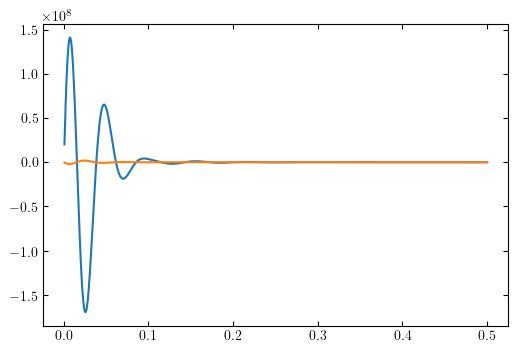

In [7]:
kh = np.linspace(0.001, .5, num=1000)
dos = np.array([svy.bispectrum_derivative_analytical((x, 0.1, 1), coordinate='child18',) for x in kh])
plt.plot(kh, dos[:,0])
plt.plot(kh, dos[:,1])

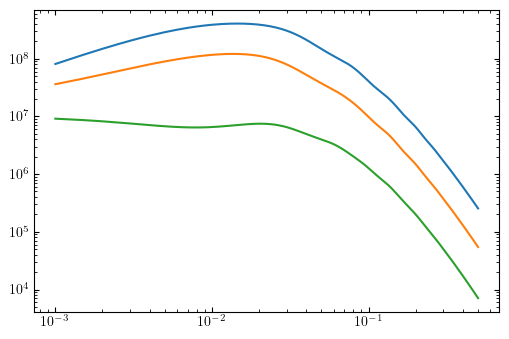

In [8]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_bias((x, 0.1, 1), coordinate='child18',) for x in kh])
plt.loglog(kh, dps[:,0])
plt.loglog(kh, dps[:,1])
plt.loglog(kh, dps[:,2])

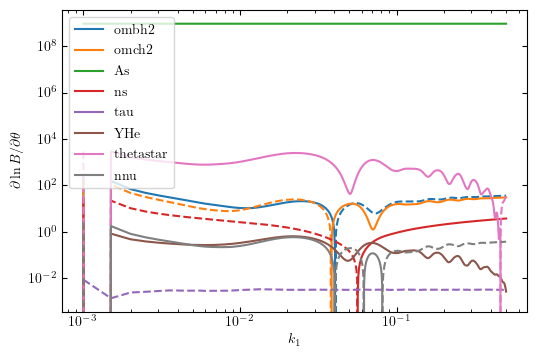

In [9]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, 0.1, 1), coordinate='child18',)\
                /svy.bispectrum((x, 0.1, 1), coordinate='child18',) for x in kh])
for i, l in zip(range(len(svy.cosmological_parameters_in_fisher)), svy.cosmological_parameters_in_fisher):
    pl = plt.loglog(kh, dps[:,i], label=l)
    plt.loglog(kh, -dps[:,i], c=pl[0].get_color(), ls='--')
    
plt.ylabel(r'$\partial \ln B/\partial \theta$')
plt.xlabel('$k_1$')
plt.legend()

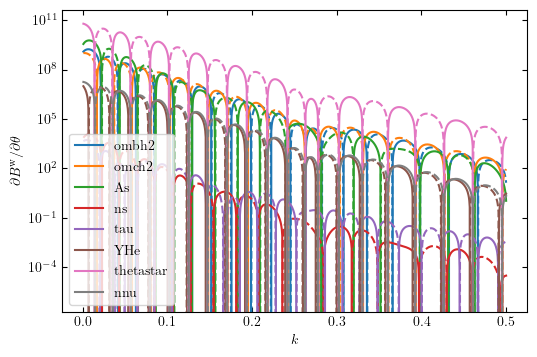

In [10]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*1, np.pi/2), coordinate='child18',
                wiggle_only=True) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, dps[:,i], label=l)
    plt.plot(kh, -dps[:,i], c=pl[0].get_color(), ls='--')

plt.ylabel(r'$\partial B^{\rm w}/\partial \theta$')
plt.xlabel('$k$')
plt.legend()

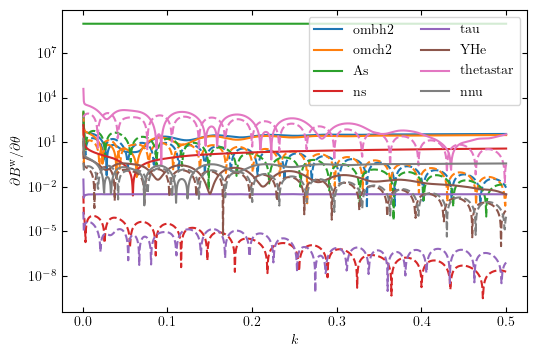

In [11]:
kh = np.linspace(0.001, .5, num=1000)

xx = 2
yy = 0.0001

dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*xx, np.pi*yy), coordinate='child18',
                wiggle_only=False)/svy.bispectrum((x, svy.pisf*xx, np.pi*yy), coordinate='child18',) for x in kh])
dpws = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*xx, np.pi*yy), coordinate='child18',
                wiggle_only=True)/svy.bispectrum((x, svy.pisf*xx, np.pi*yy), coordinate='child18',) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, np.abs(dps[:,i]), label=l)
    plt.semilogy(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())

plt.ylabel(r'$\partial B^{\rm w}/\partial \theta$')
plt.xlabel('$k$')
plt.legend(ncol=2)

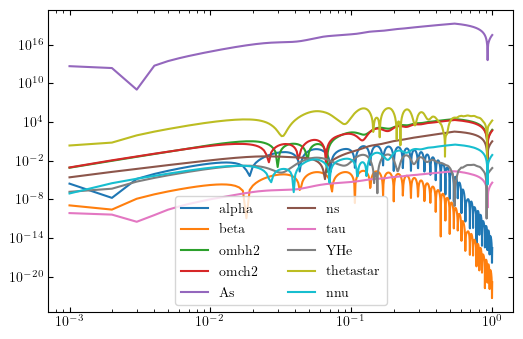

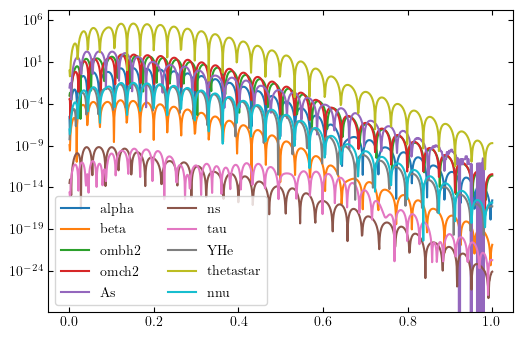

In [12]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

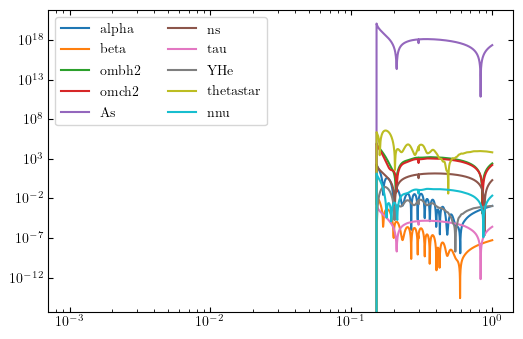

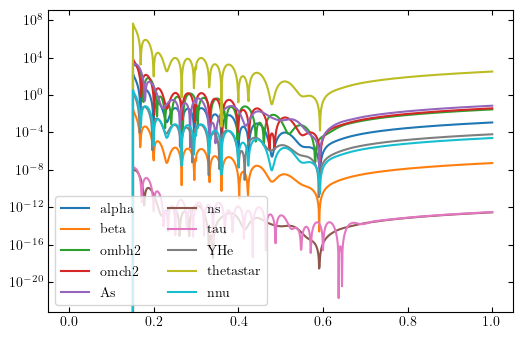

In [13]:
kh = np.linspace(0.001, 1, num=1000)
k1 = 0.01

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, x, .3, 0, 0), 0, coordinate='cartesian',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, x, .3, 0, 0), 0, coordinate='cartesian',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

<ipython-input-22-06ed6841867d>:13: RuntimeWarning: divide by zero encountered in log10
  db[xx, yy] = np.log10(svy.integrand_bs((X[xx, yy], Y[xx, yy], k3, 0, 0), 0, unique=True, coordinate='cartesian',wiggle_only=True, k_max_bi=k_max)[i, i])


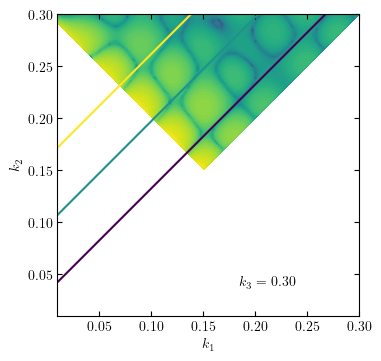

In [22]:
k_max = 0.3
k3 = 0.3
X = np.linspace(0.01, k_max, num=100)
Y = np.linspace(0.01, k_max, num=100)
X, Y = np.meshgrid(X, Y)
i = 9

db = np.zeros(X.shape)
ct = np.zeros(X.shape)
ct2 = np.zeros(X.shape)
for xx in range(len(X)):
    for yy in range(len(Y)):
        db[xx, yy] = np.log10(svy.integrand_bs((X[xx, yy], Y[xx, yy], k3, 0, 0), 0, unique=True, coordinate='cartesian',wiggle_only=True, k_max_bi=k_max)[i, i])
        ct[xx, yy] = (Y[xx, yy]-X[xx, yy])/(svy.pisf)
        ct2[xx, yy] = (Y[xx, yy]+X[xx, yy])/(svy.pisf)
        
fig, ax = plt.subplots()
ax.contourf(X, Y, db, levels=100)
ax.contour(X, Y, ct, levels=[1, 3, 5])
#ax.contour(X, Y, ct2, levels=[9, 11, 13])
ax.set_aspect('equal')
ax.set_xlabel('$k_1$')
ax.set_ylabel('$k_2$')
ax.annotate('$k_3=%.2f$'%k3, (0.6, 0.1), xycoords='axes fraction')
plt.show()

Text(0, 0.5, 'Information')

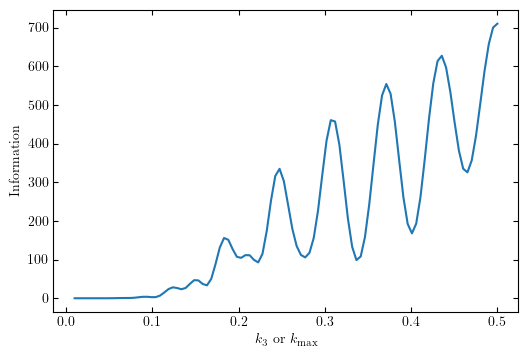

In [16]:
k_max = 0.5

X = np.linspace(0.01, k_max, num=100)
Y = np.linspace(0.01, k_max, num=100)
X, Y = np.meshgrid(X, Y)
i = 9

k3s = np.linspace(0.01, 0.5, num=100)
ints = []
for k3 in k3s:
    db = np.zeros(X.shape)
    for xx in range(len(X)):
        for yy in range(len(Y)):
            db[xx, yy] = (svy.integrand_bs((X[xx, yy], Y[xx, yy], k3, 0, 0), 0, unique=True, coordinate='cartesian',wiggle_only=True, k_max_bi=k_max)[i, i])
    ints.append(np.sum(db))

plt.plot(k3s, ints)
plt.xlabel(r'$k_3$ or $k_{\rm max}$')
plt.ylabel('Information')

No handles with labels found to put in legend.


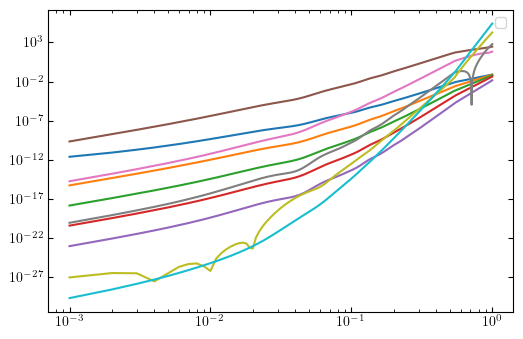

No handles with labels found to put in legend.


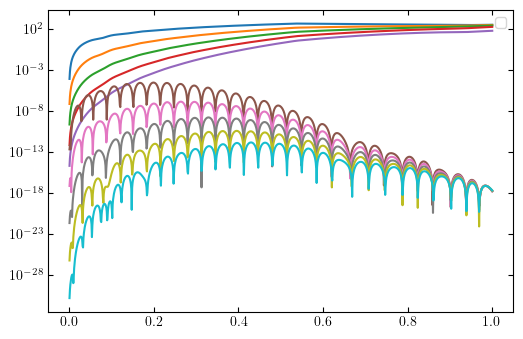

In [16]:
kh = np.linspace(0.001, 1, num=1000)

for i in range(13, 23):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp)    
plt.legend(ncol=2)
plt.show()

for i in range(13, 23):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp)    
plt.legend(ncol=2)
plt.show()

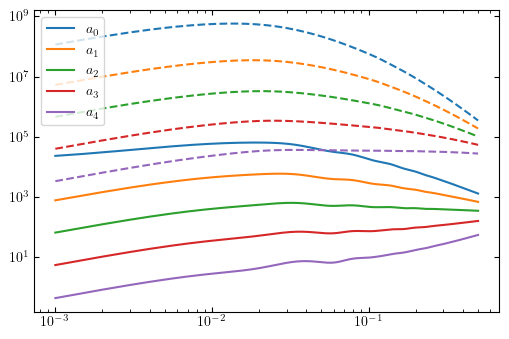

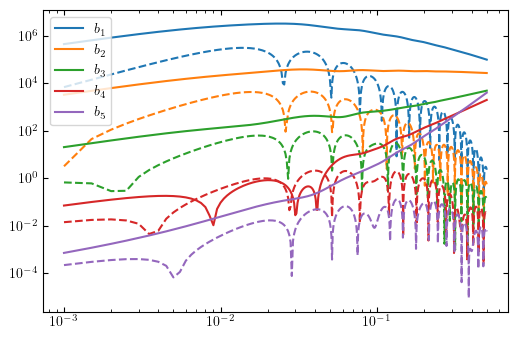

In [17]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_polynomial((x, 0.1, 1), coordinate='child18') for x in kh])
dpws = np.array([svy.bispectrum_derivative_polynomial((x, 0.1, 1), coordinate='child18',
                                                                  wiggle_only=True) for x in kh])
a = svy.polynomial_parameters['a']
b = svy.polynomial_parameters['b']
for i, l in zip(range(len(a)), a):
    pl = plt.loglog(kh, np.abs(dps[:,i]), label='$a_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

for i, l in zip(range(len(a), len(a)+len(b)), b):
    pl = plt.loglog(kh, np.abs(dps[:,i]), label='$b_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

In [53]:
svy.update_survey_setups(
                         survey_geometrics={'f_sky': 0.5,'N_g': 1e100,'z_min': 0.1,'z_max': 4.0,'dz': 0.1,'Sigma_0': 16.6,'reconstruction_rate': 0.5,'b_0': 0.95,'survey_type':'spectroscopic','sigma8_0': 0.9,},
                         )

In [15]:
%timeit svy.integrand_bs((0.01, 0.1, 1, 0, 0), 0, coordinate='child18')

3.85 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
fs = svy.get_bispectrum_fisher_matrix()

In [76]:
fs.slice(['alpha', 'beta'], exclude=True).constraints()[1]['nnu']

0.20155122937596187

In [77]:
sb2sn(fs.slice(['thetastar', 'nnu'], exclude=True).constraints()[1]['beta'])

0.6704678413092431

In [82]:
import h5py
with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)

Removed no burn in
Removed no burn in


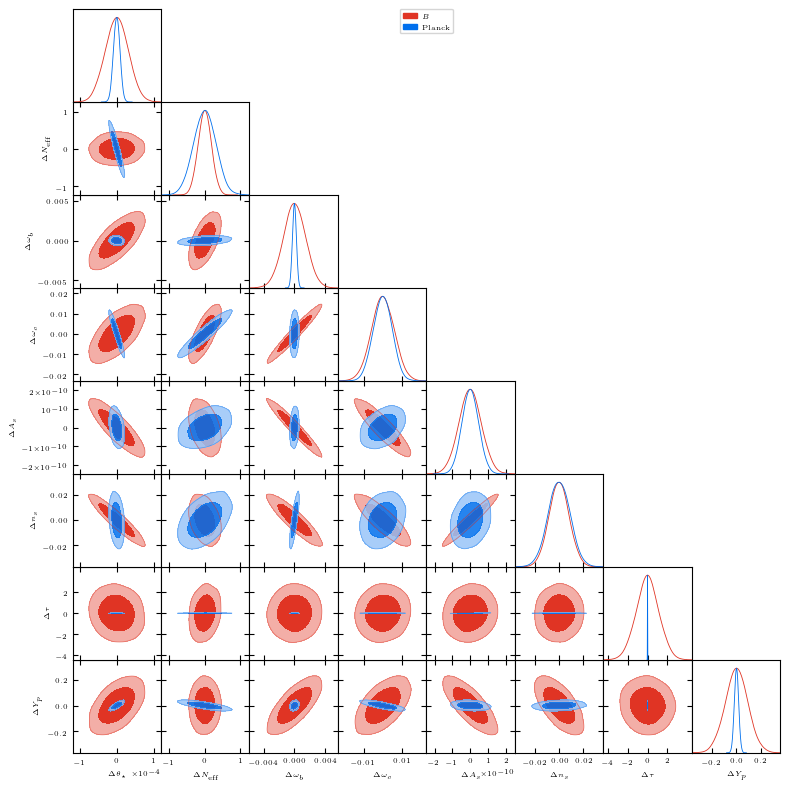

In [96]:
reload(fm)
keys = ['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']
labels =  [r'$\Delta\theta_\star$', r'$\Delta N_{\rm eff}$', r'$\Delta\omega_b$', r'$\Delta\omega_c$', 
           r'$\Delta A_s$', r'$\Delta n_s$', r'$\Delta\tau$', r'$\Delta Y_p$']
fm.triangle_plot([fs, cmb_fisher], keys=keys, fisher_labels=['$B$', 'Planck'], parameter_labels=labels)

In [71]:
with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)
fs.slice(['alpha', 'beta'], exclude=True).merge(cmb_fisher).constraints()[1]['nnu']

0.05215719970354141

In [75]:
with h5py.File('planck_cmb_fisher.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)
sb2sn(fs.slice(['thetastar', 'nnu'], exclude=True).merge(cmb_fisher).constraints()[1]['beta'])

0.06406030297083447

## Idealized surveys

In [1]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy
import h5py

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

import fisher_matrix as fm
import defaults as df
reload(df)

<module 'defaults' from 'C:\\Users\\yanlo\\Dropbox\\galaxy_survey\\defaults.py'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [3]:
svy = gs.survey(cosmological_parameters_in_fisher=[])

In [50]:
sg = {'f_sky': 0.5,'N_g': 1e100,'z_min': 0.1,'z_max': 4.0,'dz': 0.1,'Sigma_0': 16.6,'b_0': 0.95,'survey_type':'spectroscopic','sigma8_0': 0.9,}
ig = ['RSD', 'damping', 'galactic_bias', 'ap_effect', 'shot_noise', 'reconstruction']

In [4]:
with h5py.File("idealized_survey_fisher_matrix.hdf5", "w+") as f:
    for ng in [1e6, 1e7, 1e8, 1e100]:
        sg['N_g'] = ng
        key_svy = 'Ng_%.0e'%ng
        group_svy = f.create_group(key_svy)
        zs = list(np.arange(0.25, 1.8, 0.1))+list(np.arange(2, 4.1, 0.25))
        zs = np.linspace(0.3, 4, num=38)
        print(key_svy, end='\t')
        for z_max in zs:
            sg['z_max'] = z_max
            key_zmax = '%.6f'%z_max
            group_zmax = group_svy.create_group(key_zmax)
            svy.update_survey_setups(survey_geometrics=sg, ingredients=ig)
            print('%.2f'%sg['z_max'], end=' ')
            
            regions=[{'k_min': 0.02,'k_max': 0.5,'mu_min': -1.0,'mu_max': 1.0}]
            fsp = svy.get_power_spectrum_fisher_matrix(regions=regions, wiggle_only=True, div_mu=25, physical_kmin=False)
            fsb = svy.get_bispectrum_fisher_matrix(wiggle_only=True)
            print(fsp.keys)
            
            key_fs = 'P'
            group_fs = group_zmax.create_group(key_fs)
            fsp.write_hdf5(group_fs)
            
            key_fs = 'B'
            group_fs = group_zmax.create_group(key_fs)
            fsb.write_hdf5(group_fs)
    

Ng_1e+06	0.30 ['beta', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin0.20_zmax0.30']
0.40 ['beta', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.10_zmax0.20']
0.50 ['beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.60 ['alpha-zmin0.50_zmax0.60', 'beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.70 ['alpha-zmin0.50_zmax0.60', 'beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.80 ['alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'beta', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin0.50_zmax0.60']
0.90 ['alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.80_zmax0.90', 'beta', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin0.30_zmax0.40', 'a

In [48]:
svy = gs.survey()

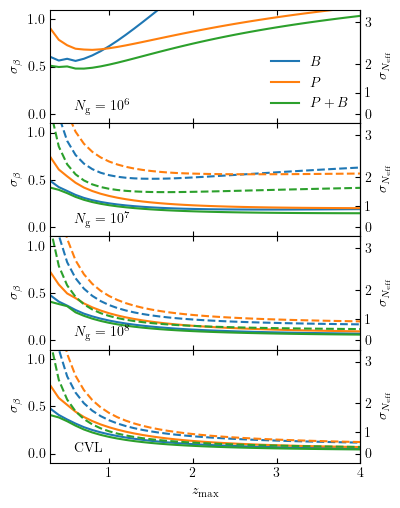

In [56]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5').slice(
    ['ombh2', 'omch2', 'As', 'ns', 'tau', 'thetastar', 'nnu', ])

matplotlib.rcParams['ytick.right'] = False
fig, axs = plt.subplots(4, 1, figsize=(4, 6))

with h5py.File("idealized_survey_fisher_matrix.hdf5", "r") as f:
    for ng, i in zip([1e6, 1e7, 1e8, 1e100], range(4)):
        sg['N_g'] = ng
        key_svy = 'Ng_%.0e'%ng
        group_svy = f[key_svy]
        zs = np.linspace(0.3, 4, num=38)
        sbs = []
        for z_max in zs:
            sg['z_max'] = z_max
            key_zmax = '%.6f'%z_max
            group_zmax = group_svy[key_zmax]
            svy.update_survey_setups(survey_geometrics=sg, ingredients=ig)
            svy.prepare_alpha_transfer_matrix()
            dadp = svy.alpha_transfer_matrix
            #print(dadp)
            if z_max==0.2:
                continue
            else:
                dadp = np.delete(dadp, 5, 1)
            dadp_pi = np.linalg.pinv(dadp)
            s = dadp_pi.T.dot(cmb_fisher.matrix).dot(dadp_pi)
            cp = fm.fisher(s, svy.alpha_transfer_matrix_entries)
            
            fsp = fm.read_hdf5(group_zmax['P']).slice(['alpha', 'beta'], fuzzy_filter=True)
            fsb = fm.read_hdf5(group_zmax['B']).slice(['alpha', 'beta'], fuzzy_filter=True)
            # print(z_max, cp.keys)
            
            ss = []
            for fs in [fsp.merge(cp), fsb.merge(cp), fsp.merge(fsb).merge(cp), fsp, fsb, fsp.merge(fsb)]:
                sb = fs.constraints()[1]['beta']
                sn = df.sb2sn(sb)
                ss.append(sb)
            sbs.append(ss)
        
        sbs = np.array(sbs)
        ax = axs[i]
        p = ax.plot(zs[:], sbs[:,1], label=r'$B$')
        p = ax.plot(zs[:], sbs[:,4], ls='--', c=p[0].get_color())
        p = ax.plot(zs[:], sbs[:,0], label=r'$P$')
        p = ax.plot(zs[:], sbs[:,3], ls='--', c=p[0].get_color())
        p = ax.plot(zs[:], sbs[:,2], label=r'$P+B$')
        p = ax.plot(zs[:], sbs[:,5], ls='--', c=p[0].get_color())
        
        if i==0:
            ax.legend(loc='lower right', frameon=False)
        if ng<1e100:
            lb = r'$N_{\rm g}=10^{%d}$'%(np.log10(ng))
        else:
            lb = 'CVL'
        ax.annotate(lb, (0.075, 0.075), xycoords='axes fraction', ha='left', va='bottom')
        ax.set_ylim(-0.1, 1.1)
        
        ax.set_ylabel(r'$\sigma_\beta$')
        if i==3:
            ax.set_xlabel(r'$z_{\rm max}$')
        else:
            ax.set_xticklabels([])
            
            
        ax_t = ax.secondary_yaxis("right", functions=(df.sb2sn_full, df.sn2sb_full))
        ticks = list(range(13))
        tick_lbs = ['0', '1', '2', '3', '4', '5', '6', '', '', '9', '', '', '12']
        ax_t.set_yticks(ticks)

        ax_t.set_yticklabels(tick_lbs)
        ax_t.set_ylabel(r'$\sigma_{N_{\rm eff}}$')

#         if i%2==0:
#             ax_t.set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig('plots/constraints_idealized_surveys.pdf', bbox_inches='tight')

In [7]:
matplotlib.rcParams['ytick.right'] = True

## Survey results

In [5]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy
import h5py

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

import fisher_matrix as fm
import defaults as df
reload(df)

<module 'defaults' from 'C:\\Users\\yanlo\\Dropbox\\galaxy_survey\\defaults.py'>

In [6]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['axes.xmargin'] = 0

In [7]:
dfs = df.defaults()

In [4]:
svy = gs.survey()

Text(0, 0.5, '$r(z)$')

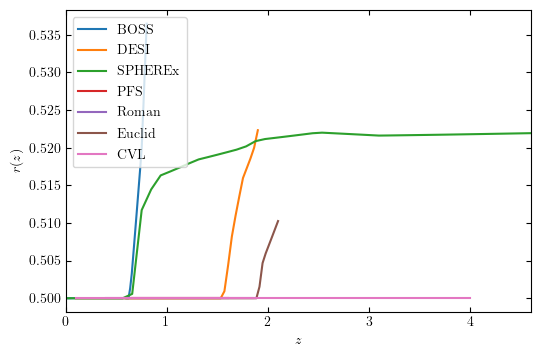

In [5]:
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid, dfs.cvl]
for survey in surveys:
    svy.update_survey_setups(survey_geometrics=survey)
    lbl = survey['name']
    zs = np.linspace(svy.z_min, svy.z_max)
    rs = [svy.reconstruction_rate(z) for z in zs]
    plt.plot(zs, rs, label=lbl)
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$r(z)$')

In [160]:
surveys = [dfs.boss, dfs.desi, dfs.euclid, dfs.pfs, dfs.spherex, dfs.roman]
for svy in surveys:
    cs = 6
    zmid_ng = svy['ng_z_list'][:,:2]
    nz = len(zmid_ng)
    
    zs = ['%.3f'%(x[0]) for x in zmid_ng]+[' ']*((cs-nz%cs)%cs)
    ngs = ['%.3f'%(x[1]*1e3) for x in zmid_ng]+[' ']*((cs-nz%cs)%cs)
    zl = r'$z_{\rm mid}$'
    nl = r'$10^3n_{\rm g}$'#'[({\rm Mpc}/h)^{-3}]$'
    
    
    print("""\\begin{subtable}{\\linewidth}
\\begin{tabularx}{\\textwidth}{%s}"""%('X'*(cs+1))
         )
    print('\\toprule')
    for i in range(len(zs)//cs):
        print(zl, end=' ')
        for j in range(cs):
            print('&'+zs[i*cs+j], end=' ')
        print('\\\\')
        
        print(nl, end=' ')
        for j in range(cs):
            print('&'+ngs[i*cs+j], end=' ')
        print('\\\\')
        if i<len(zs)//cs-1:
            print('\\midrule')
            
    print('\\bottomrule')
          
    print('\\end{tabularx}\n\\caption{%s: $f_{\\rm sky}=%.3f$ (%.0f square degrees).}\n\\end{subtable}'%(
        svy['name'], svy['f_sky'], svy['f_sky']*4*np.pi*(180/np.pi)**2)
         )
    print(' ')

\begin{subtable}{\linewidth}
\begin{tabularx}{\textwidth}{XXXXXXX}
\toprule
$z_{\rm mid}$ &0.050 &0.150 &0.250 &0.350 &0.450 &0.550 \\
$10^3n_{\rm g}$ &0.289 &0.290 &0.300 &0.304 &0.276 &0.323 \\
\midrule
$z_{\rm mid}$ &0.650 &0.750 &  &  &  &  \\
$10^3n_{\rm g}$ &0.120 &0.010 &  &  &  &  \\
\bottomrule
\end{tabularx}
\caption{BOSS: $f_{\rm sky}=0.242$ (10000 square degrees).}
\end{subtable}
 
\begin{subtable}{\linewidth}
\begin{tabularx}{\textwidth}{XXXXXXX}
\toprule
$z_{\rm mid}$ &0.150 &0.250 &0.350 &0.450 &0.550 &0.650 \\
$10^3n_{\rm g}$ &2.380 &1.070 &0.684 &0.568 &0.600 &0.696 \\
\midrule
$z_{\rm mid}$ &0.750 &0.850 &0.950 &1.050 &1.150 &1.250 \\
$10^3n_{\rm g}$ &0.810 &0.720 &0.560 &0.520 &0.510 &0.450 \\
\midrule
$z_{\rm mid}$ &1.350 &1.450 &1.550 &1.650 &1.750 &1.850 \\
$10^3n_{\rm g}$ &0.360 &0.240 &0.130 &0.070 &0.030 &0.010 \\
\bottomrule
\end{tabularx}
\caption{DESI: $f_{\rm sky}=0.339$ (14000 square degrees).}
\end{subtable}
 
\begin{subtable}{\linewidth}
\begin{tabularx}

In [132]:
svy

{'short_name': 'roman',
 'name': 'Roman',
 'f_sky': 0.04848136811095359,
 'ng_z_list': array([[4.25000e-01, 4.81597e-04, 5.00000e-02],
        [4.75000e-01, 6.37815e-04, 5.00000e-02],
        [5.25000e-01, 8.62085e-04, 5.00000e-02],
        [5.75000e-01, 9.75034e-04, 5.00000e-02],
        [6.25000e-01, 1.13424e-03, 5.00000e-02],
        [6.75000e-01, 1.24195e-03, 5.00000e-02],
        [7.25000e-01, 1.26636e-03, 5.00000e-02],
        [7.75000e-01, 1.28249e-03, 5.00000e-02],
        [8.25000e-01, 1.24766e-03, 5.00000e-02],
        [8.75000e-01, 1.22441e-03, 5.00000e-02],
        [9.25000e-01, 1.18900e-03, 5.00000e-02],
        [9.75000e-01, 1.11994e-03, 5.00000e-02],
        [1.02500e+00, 1.05326e-03, 5.00000e-02],
        [1.07500e+00, 9.83852e-04, 5.00000e-02],
        [1.12500e+00, 9.03046e-04, 5.00000e-02],
        [1.17500e+00, 8.42235e-04, 5.00000e-02],
        [1.22500e+00, 7.69216e-04, 5.00000e-02],
        [1.27500e+00, 7.13216e-04, 5.00000e-02],
        [1.32500e+00, 6.44830e-0

In [12]:
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid, dfs.cvl]

with h5py.File("survey_fisher_matrix.hdf5", "w") as f:
    for survey in surveys:
        svy.update_survey_setups(survey_geometrics=survey)
        key_svy = survey['short_name']
        print(key_svy, end='\t')
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
            group_svy.attrs['zmax'] = svy.z_max
        else:
            group_svy = f[key_svy]
        for x, l in zip([True, False], ['w', '']):
            if x:
                regions=[{'k_min': 0.01,'k_max': 0.5,'mu_min': -1.0,'mu_max': 1.0}]
            else:
                regions=[{'k_min': 0.01,'k_max': 0.2,'mu_min': -1.0,'mu_max': 1.0}]
            fsp = svy.get_power_spectrum_fisher_matrix(regions=regions, wiggle_only=x, div_mu=50)
            fsb = svy.get_bispectrum_fisher_matrix(wiggle_only=x, direct_poly_derivative=True)
            
            key_fs = 'P'+l
            if key_fs not in list(group_svy.keys()):
                group_fs = group_svy.create_group(key_fs)
            fsp.write_hdf5(group_fs)
            
            key_fs = 'B'+l
            if key_fs not in list(group_svy.keys()):
                group_fs = group_svy.create_group(key_fs)
            fsb.write_hdf5(group_fs)

boss	desi	spherex	pfs	roman	euclid	cvl	

In [13]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
# CMB+LSS

print('cmb', end='\t')
sb = cmb_fisher.constraints()[1]['nnu']
print('%8.3f (C)'%(sb), end='\n')
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key])
            sb = fs.slice(['alpha', 'beta',], exclude=True, fuzzy_filter=True).constraints()[1]['nnu']
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = fs.merge(cmb_fisher).slice(['alpha', 'beta', ], exclude=True).constraints()[1]['nnu']
            print('%.3f (C+%s)'%(sb, fs_key), end=' ')
        print('')

cmb	   0.317 (C)
boss	  14.133 (B) 0.255 (C+B) 2788.964 (Bw) 0.282 (C+Bw)    8.346 (P) 0.279 (C+P)   54.205 (Pw) 0.293 (C+Pw) 
cvl	   1.061 (B) 

KeyboardInterrupt: 

In [11]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher.hdf5')
# CMB + LSS (phase shift)

print('cmb', end='\t')
sb = df.sb2sn_full(cmb_fisher.constraints()[1]['beta'])
print('%8.3f (C)'%(sb), end='\n')
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key]).slice(['nnu', 'thetastar'], exclude=True)
            sb = df.sb2sn_full(fs.constraints()[1]['beta'])
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = df.sb2sn_full(fs.merge(cmb_fisher).constraints()[1]['beta'])
            print('%.3f (C+%s)'%(sb, fs_key), end=' ')
        print('')

cmb	   0.305 (C)
boss	   4.673 (B) 0.112 (C+B)    6.762 (Bw) 0.133 (C+Bw)    5.336 (P) 0.171 (C+P)    5.670 (Pw) 0.155 (C+Pw) 
cvl	   0.756 (B) 0.067 (C+B)    3.121 (Bw) 0.090 (C+Bw)    2.810 (P) 0.115 (C+P)    1.457 (Pw) 0.108 (C+Pw) 
desi	   2.181 (B) 0.082 (C+B)    5.324 (Bw) 0.115 (C+Bw)    3.105 (P) 0.118 (C+P)    3.433 (Pw) 0.119 (C+Pw) 
euclid	   1.789 (B) 0.079 (C+B)    4.915 (Bw) 0.111 (C+Bw)    2.729 (P) 0.113 (C+P)    2.983 (Pw) 0.117 (C+Pw) 
pfs	   4.092 (B) 0.101 (C+B)    6.566 (Bw) 0.128 (C+Bw)    5.061 (P) 0.171 (C+P)    5.366 (Pw) 0.149 (C+Pw) 
roman	   3.515 (B) 0.095 (C+B)    6.296 (Bw) 0.123 (C+Bw)    4.712 (P) 0.151 (C+P)    4.901 (Pw) 0.132 (C+Pw) 
spherex	   3.061 (B) 0.091 (C+B)    5.994 (Bw) 0.119 (C+Bw)    3.779 (P) 0.126 (C+P)    4.023 (Pw) 0.122 (C+Pw) 


In [12]:
ap = dfs.alpha_prior
# alpha prior + LSS
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key]).slice(['alpha', 'beta'], exclude=False)
            sb = df.sb2sn_full(fs.constraints()[1]['beta'])
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = df.sb2sn_full(fs.merge(ap).constraints()[1]['beta'])
            print('%.3f (a+%s)'%(sb, fs_key), end=' ')
        print('')

boss	   3.749 (B) 2.170 (a+B)    3.749 (Bw) 2.170 (a+Bw)    4.377 (P) 2.558 (a+P)    4.076 (Pw) 2.554 (a+Pw) 
cvl	   0.542 (B) 0.530 (a+B)    0.542 (Bw) 0.530 (a+Bw)    0.850 (P) 0.818 (a+P)    0.559 (Pw) 0.553 (a+Pw) 
desi	   1.559 (B) 1.303 (a+B)    1.559 (Bw) 1.303 (a+Bw)    2.124 (P) 1.666 (a+P)    1.796 (Pw) 1.544 (a+Pw) 
euclid	   1.275 (B) 1.127 (a+B)    1.275 (Bw) 1.127 (a+Bw)    1.804 (P) 1.508 (a+P)    1.458 (Pw) 1.326 (a+Pw) 
pfs	   3.302 (B) 1.997 (a+B)    3.302 (Bw) 1.997 (a+Bw)    4.042 (P) 2.397 (a+P)    3.636 (Pw) 2.394 (a+Pw) 
roman	   2.732 (B) 1.808 (a+B)    2.732 (Bw) 1.808 (a+Bw)    3.544 (P) 2.212 (a+P)    3.060 (Pw) 2.192 (a+Pw) 
spherex	   2.191 (B) 1.613 (a+B)    2.191 (Bw) 1.613 (a+Bw)    2.699 (P) 1.896 (a+P)    2.332 (Pw) 1.836 (a+Pw) 


In [34]:
# default result
# P, B, P+B, Pw, Bw, Pw+Bw
reload(fm)
reload(df)
cmb_fisher = fm.read_hdf5('cmb_s4_cmb_fisher_original.hdf5')

keys = ['thetastar', 'nnu', 'omch2', 'ombh2', 'As', 'ns', 'tau', 'YHe', ]
sn = cmb_fisher.slice(keys).constraints()[1]['nnu']
print(sn)

cps_ex = ['alpha', 'beta']
polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]


with h5py.File("survey_fisher_matrix_kmax_poly.hdf5", "r") as f:
    for svy_key in ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman', ]:
        print(getattr(dfs, svy_key)['name'], end=' ')
        key_k = str(18)
        fv = f[svy_key]
        fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        if svy_key == 'cvl':
            fsp.matrix = fsp.matrix*2
            fsb.matrix = fsb.matrix*2
            fspw.matrix = fspw.matrix*2
            fsbw.matrix = fsbw.matrix*2
        for fs in [fspw, fsbw, fspw.merge(fsbw)]:
            fp = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True)
            # print(fp.keys)
            sb = fp.constraints()[1]['nnu']
            print('& %.3f'%sb, end=' ')
        print('\\\\')
        
        
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in ['cvl']:
        group_svy = f[svy_key]
        print(getattr(dfs, svy_key)['name'], end=' ')
        fsp = fm.read_hdf5(group_svy['P']).slice(polys_ex, exclude=True, fuzzy_filter=True)
        fsb = fm.read_hdf5(group_svy['B']).slice(polys_ex, exclude=True, fuzzy_filter=True)
        fspw = fm.read_hdf5(group_svy['Pw']).slice(polys_ex_w, exclude=True, fuzzy_filter=True)
        fsbw = fm.read_hdf5(group_svy['Bw']).slice(polys_ex_w, exclude=True, fuzzy_filter=True)
        if svy_key == 'cvl':
            fsp.matrix = fsp.matrix*2
            fsb.matrix = fsb.matrix*2
            fspw.matrix = fspw.matrix*2
            fsbw.matrix = fsbw.matrix*2
        for fs in [fspw, fsbw, fspw.merge(fsbw)]:
            fp = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True)
            # print(fp.keys)
            sb = fp.constraints()[1]['nnu']
            print('& %.3f'%sb, end=' ')
        print('\\\\')
        
        
        
with h5py.File("survey_fisher_matrix_kmax_poly.hdf5", "r") as f:
    for svy_key in ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman', ]:
        print(getattr(dfs, svy_key)['name'], end=' ')
        key_k = str(18)
        fv = f[svy_key]
        fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        if svy_key == 'cvl':
            fsp.matrix = fsp.matrix*2
            fsb.matrix = fsb.matrix*2
            fspw.matrix = fspw.matrix*2
            fsbw.matrix = fsbw.matrix*2
        for fs in [fsp, fsb, fsp.merge(fsb), ]:
            fp = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True)
            sb = fp.constraints()[1]['nnu']
            print('& %.3f'%sb, end=' ')
        print('\\\\')
        
        
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in ['cvl']:
        group_svy = f[svy_key]
        print(getattr(dfs, svy_key)['name'], end=' ')
        fsp = fm.read_hdf5(group_svy['P']).slice(polys_ex, exclude=True, fuzzy_filter=True)
        fsb = fm.read_hdf5(group_svy['B']).slice(polys_ex, exclude=True, fuzzy_filter=True)
        fspw = fm.read_hdf5(group_svy['Pw']).slice(polys_ex_w, exclude=True, fuzzy_filter=True)
        fsbw = fm.read_hdf5(group_svy['Bw']).slice(polys_ex_w, exclude=True, fuzzy_filter=True)
        if svy_key == 'cvl':
            fsp.matrix = fsp.matrix*2
            fsb.matrix = fsb.matrix*2
            fspw.matrix = fspw.matrix*2
            fsbw.matrix = fsbw.matrix*2
        for fs in [fsp, fsb, fsp.merge(fsb), ]:
            fp = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True)
            sb = fp.constraints()[1]['nnu']
            print('& %.3f'%sb, end=' ')
        print('\\\\')

0.08384858859138626
BOSS & 0.083 & 0.082 & 0.082 \\
DESI & 0.081 & 0.077 & 0.077 \\
Euclid & 0.081 & 0.076 & 0.075 \\
PFS & 0.083 & 0.082 & 0.081 \\
SPHEREx & 0.082 & 0.079 & 0.079 \\
Roman & 0.083 & 0.081 & 0.080 \\
CVL & 0.057 & 0.054 & 0.044 \\
BOSS & 0.081 & 0.080 & 0.077 \\
DESI & 0.068 & 0.059 & 0.054 \\
Euclid & 0.064 & 0.054 & 0.048 \\
PFS & 0.080 & 0.079 & 0.075 \\
SPHEREx & 0.073 & 0.069 & 0.064 \\
Roman & 0.078 & 0.075 & 0.071 \\
CVL & 0.032 & 0.024 & 0.021 \\


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


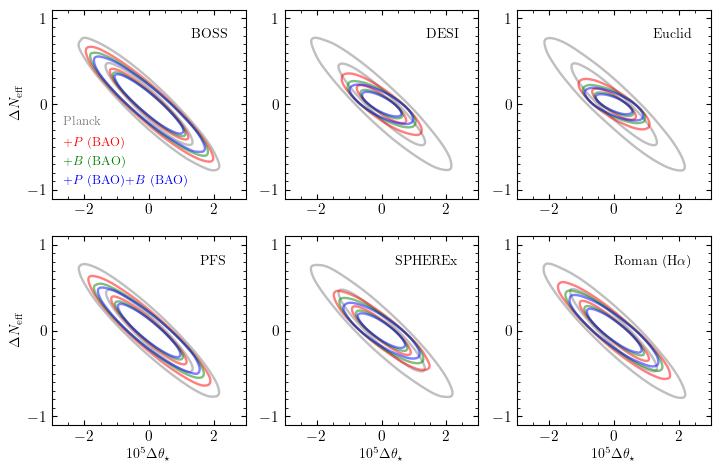

<Figure size 600x450 with 0 Axes>

In [64]:
from getdist import plots, MCSamples
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

show_wiggles_only = True


fig, axs = plt.subplots(2, 3, figsize=(8.5, 5.5))

colors = ['grey', 'red', 'green', 'blue',]
alphas = [0.5]*4

legends = [r'Planck', r'+$P$', r'+$B$', r'+$P$+$B$']
if show_wiggles_only:
    legends = [r'Planck', r'+$P$ (BAO)', r'+$B$ (BAO)', r'+$P$ (BAO)+$B$ (BAO)']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
norms = {'thetastar': 1e5,'ombh2': 1e4,'As': 1e10,}
svys_label = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'SPHEREx', r'Roman (H$\alpha$)']
random_state = np.random.default_rng(10)
g = plots.get_single_plotter()

with h5py.File('survey_fisher_matrix.hdf5', 'r') as f:
    for r in range(2):
        for i in range(3):
            ax = axs[r, i]
            svy_key = svys_label[r*3+i]
            group_svy = f[svy_key]
            title = svys_title[r*3+i]
            ax.annotate(title, (0.9, 0.9), xycoords='axes fraction', ha='right', va='top')
            #ax.set_title(title)

            fishers = []
            prior = cmb_fisher
            fishers.append(prior)
            if show_wiggles_only:
                fsp = fm.read_hdf5(group_svy['Pw']).slice(['poly', ], fuzzy_filter=True, exclude=True)
                fsb = fm.read_hdf5(group_svy['Bw']).slice(['poly', ], fuzzy_filter=True, exclude=True)
            else:
                fsp = fm.read_hdf5(group_svy['P']).slice(['poly', ], fuzzy_filter=True, exclude=True)
                fsb = fm.read_hdf5(group_svy['B']).slice(['poly', ], fuzzy_filter=True, exclude=True)
            
            fspb = fsp.merge(fsb)
            
            fsp = fsp.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)
            fsb = fsb.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)
            fspb = fspb.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)

            fishers.append(fsp)
            fishers.append(fsb)
            fishers.append(fspb)

            samples = []
            for fisher, legend in zip(fishers, legends):
                cov = fisher.normalize(norms).matrix
                cc = np.linalg.inv(cov)
                samps = random_state.multivariate_normal([0]*fisher.ndim, cc, size=100000)
                samples.append(MCSamples(samples=samps,names=fisher.keys, labels=fisher.keys, label=legend))
#             g.plot_1d(samples, 'thetastar', filled=False, ax=ax, lims=[-3, 3,],
#                      do_xlabel=False, do_ylabel=False, colors=colors, alphas=alphas)
            g.plot_2d(samples, ['thetastar', 'nnu'], filled=False, ax=ax, lims=[-3, 3, -1.1, 1.1],
                     do_xlabel=False, do_ylabel=False, colors=colors, alphas=alphas)
            if i==0 and r==0:
                g.settings.figure_legend_frame = False
#                 g.add_legend(legends, legend_loc='upper right', ax=ax, legend_ncol=7, figure_legend_outside=True,
#                             bbox_to_anchor=(0.7, 1.1, 2, .1), mode='expand', colored_text=True)
                g.add_legend(legends, legend_loc='lower left', ax=ax, colored_text=True, fontsize=9)
            
            if i == 0:
                ax.set_ylabel(r'$\Delta N_{\rm eff}$')
            if r == 1:
                ax.set_xlabel(r'$10^5 \Delta \theta_\star$')
            ax.xaxis.set_minor_locator(MultipleLocator(0.5))
            ax.yaxis.set_minor_locator(MultipleLocator(0.1))

if show_wiggles_only:
    suf = '-bao'
else:
    suf = ''
fig.savefig('plots/contours-thetastar-nnu%s.pdf'%suf, bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<ipython-input-14-5570e79a1164>:64: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([0]*fisher.ndim, cc, size=1000)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


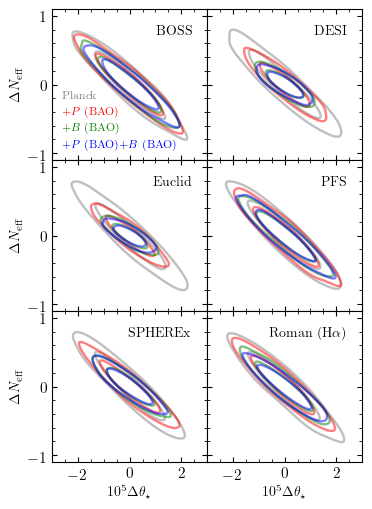

<Figure size 600x450 with 0 Axes>

In [14]:
from getdist import plots, MCSamples
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

show_wiggles_only = True

cps_ex = ['alpha', 'beta']
polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]


fig, axs = plt.subplots(3, 2, figsize=(4, 6))

colors = ['grey', 'red', 'green', 'blue',]
alphas = [0.5]*4

legends = [r'Planck', r'+$P$', r'+$B$', r'+$P$+$B$']
if show_wiggles_only:
    legends = [r'Planck', r'+$P$ (BAO)', r'+$B$ (BAO)', r'+$P$ (BAO)+$B$ (BAO)']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
norms = {'thetastar': 1e5,'ombh2': 1e4,'As': 1e10,}
svys_label = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'SPHEREx', r'Roman (H$\alpha$)']
random_state = np.random.default_rng(11)
g = plots.get_single_plotter()

with h5py.File('survey_fisher_matrix_kmax_poly.hdf5', 'r') as f:
    for r in range(3):
        for i in range(2):
            ax = axs[r, i]
            svy_key = svys_label[r*2+i]
            group_svy = f[svy_key]['18']
            title = svys_title[r*2+i]
            ax.annotate(title, (0.9, 0.9), xycoords='axes fraction', ha='right', va='top')
            #ax.set_title(title)

            fishers = []
            prior = cmb_fisher
            fishers.append(prior)
            if show_wiggles_only:
                fsp = fm.read_hdf5(group_svy['Pw']).slice(polys_ex, fuzzy_filter=True, exclude=True)
                fsb = fm.read_hdf5(group_svy['Bw']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            else:
                fsp = fm.read_hdf5(group_svy['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
                fsb = fm.read_hdf5(group_svy['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            
            fspb = fsp.merge(fsb)
            
            fsp = fsp.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)
            fsb = fsb.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)
            fspb = fspb.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)

            fishers.append(fsp)
            fishers.append(fsb)
            fishers.append(fspb)

            samples = []
            for fisher, legend in zip(fishers, legends):
                cov = fisher.normalize(norms).matrix
                cc = np.linalg.inv(cov)
                samps = random_state.multivariate_normal([0]*fisher.ndim, cc, size=1000)
                samples.append(MCSamples(samples=samps,names=fisher.keys, labels=fisher.keys, label=legend))
#             g.plot_1d(samples, 'thetastar', filled=False, ax=ax, lims=[-3, 3,],
#                      do_xlabel=False, do_ylabel=False, colors=colors, alphas=alphas)
            g.plot_2d(samples, ['thetastar', 'nnu'], filled=False, ax=ax, lims=[-3, 3, -1.1, 1.1],
                     do_xlabel=False, do_ylabel=False, colors=colors, alphas=alphas)
            if i==0 and r==0:
                g.settings.figure_legend_frame = False
#                 g.add_legend(legends, legend_loc='upper right', ax=ax, legend_ncol=7, figure_legend_outside=True,
#                             bbox_to_anchor=(0.7, 1.1, 2, .1), mode='expand', colored_text=True)
                g.add_legend(legends, legend_loc='lower left', ax=ax, colored_text=True, fontsize=8)
            
            if i == 0:
                ax.set_ylabel(r'$\Delta N_{\rm eff}$')
            else:
                ax.set_yticklabels([])
            if r == 2:
                ax.set_xlabel(r'$10^5 \Delta \theta_\star$')
            else:
                ax.set_xticklabels([])
            ax.xaxis.set_minor_locator(MultipleLocator(0.5))
            ax.yaxis.set_minor_locator(MultipleLocator(0.2))

if show_wiggles_only:
    suf = '-bao'
else:
    suf = ''

fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig('plots/contours-thetastar-nnu%s.pdf'%suf, bbox_inches='tight')
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


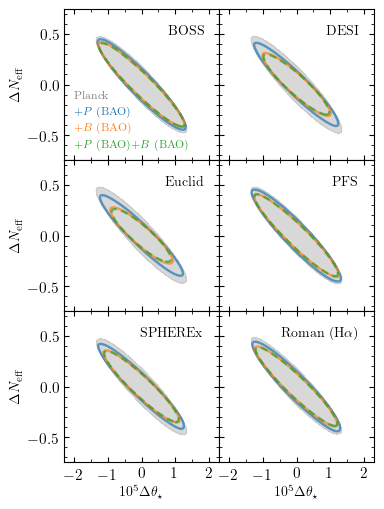

<Figure size 600x450 with 0 Axes>

In [13]:
from getdist import plots, MCSamples
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

show_wiggles_only = True

cps_ex = ['alpha', 'beta']
polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]


fig, axs = plt.subplots(3, 2, figsize=(4, 6))

colors = ['grey', 'C0', 'C1', 'C2',]
filled = [True, False, False, False]
alphas = [0.3, .7, .7, .7]

legends = [r'Planck', r'+$P$', r'+$B$', r'+$P$+$B$']
if show_wiggles_only:
    legends = [r'Planck', r'+$P$ (BAO)', r'+$B$ (BAO)', r'+$P$ (BAO)+$B$ (BAO)']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
norms = {'thetastar': 1e5,'ombh2': 1e4,'As': 1e10,}
svys_label = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'SPHEREx', r'Roman (H$\alpha$)']
random_state = np.random.default_rng(11)
g = plots.get_single_plotter()

g.settings.num_plot_contours = 1

contour_factor = 1#np.sqrt(-np.log(0.314598)*2)

with h5py.File('survey_fisher_matrix_kmax_poly.hdf5', 'r') as f:
    for r in range(3):
        for i in range(2):
            ax = axs[r, i]
            svy_key = svys_label[r*2+i]
            group_svy = f[svy_key]['18']
            title = svys_title[r*2+i]
            ax.annotate(title, (0.9, 0.9), xycoords='axes fraction', ha='right', va='top')
            #ax.set_title(title)

            fishers = []
            prior = cmb_fisher
            fishers.append(prior)
            if show_wiggles_only:
                fsp = fm.read_hdf5(group_svy['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
                fsb = fm.read_hdf5(group_svy['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            else:
                fsp = fm.read_hdf5(group_svy['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
                fsb = fm.read_hdf5(group_svy['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            
            fspb = fsp.merge(fsb)
            
            fsp = fsp.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)
            fsb = fsb.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)
            fspb = fspb.merge(prior).slice(['alpha', 'beta'], exclude=True, fuzzy_filter=True)

            fishers.append(fsp)
            fishers.append(fsb)
            fishers.append(fspb)

            samples = []
            for fisher, legend in zip(fishers, legends):
                fisher = fisher.normalize(norms).inverse().slice(['thetastar', 'nnu']).inverse()
                cov = fisher.matrix*contour_factor**2
                cc = np.linalg.inv(cov)
                samps = random_state.multivariate_normal([0]*fisher.ndim, cc, size=100000)
                samples.append(MCSamples(samples=samps,names=fisher.keys, labels=fisher.keys, label=legend))
#             g.plot_1d(samples, 'thetastar', filled=False, ax=ax, lims=[-3, 3,],
#                      do_xlabel=False, do_ylabel=False, colors=colors, alphas=alphas)
            g.plot_2d(samples, ['thetastar', 'nnu'], filled=filled, ax=ax, lims=[-2.3, 2.3, -.75, .75],
                      ls = ['-', '-', '-', '--'],
                     do_xlabel=False, do_ylabel=False, colors=colors, alphas=alphas)
            if i==0 and r==0:
                g.settings.figure_legend_frame = False
#                 g.add_legend(legends, legend_loc='upper right', ax=ax, legend_ncol=7, figure_legend_outside=True,
#                             bbox_to_anchor=(0.7, 1.1, 2, .1), mode='expand', colored_text=True)
                g.add_legend(legends, legend_loc='lower left', ax=ax, colored_text=True, fontsize=8)
            
            if i == 0:
                ax.set_ylabel(r'$\Delta N_{\rm eff}$')
            else:
                ax.set_yticklabels([])
            if r == 2:
                ax.set_xlabel(r'$10^5 \Delta \theta_\star$')
            else:
                ax.set_xticklabels([])
            ax.xaxis.set_minor_locator(MultipleLocator(0.5))
            ax.yaxis.set_minor_locator(MultipleLocator(0.1))

if show_wiggles_only:
    suf = '-bao'
else:
    suf = ''

fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig('plots/contours-thetastar-nnu%s.pdf'%suf, bbox_inches='tight')
plt.show()

In [16]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5').slice(
    ['ombh2', 'omch2', 'As', 'ns', 'tau', 'thetastar', 'nnu'])

0.6569352394668829 Removed no burn in
0.4945483170772913 Removed no burn in
0.4374688342794994 Removed no burn in
2.067167051062965 Removed no burn in
1.4652352276807783 Removed no burn in
1.1726436080610525 Removed no burn in
0.2435780593108598 Removed no burn in
0.18588186332598672 Removed no burn in
0.16828001513279192 Removed no burn in
0.5798153770123498 Removed no burn in
0.38289210057743595 Removed no burn in
0.309598891619101 Removed no burn in


<ipython-input-79-7d2e39dfbdf8>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
<ipython-input-79-7d2e39dfbdf8>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


0.1958458449532007 Removed no burn in
0.1478891521079891 Removed no burn in
0.134908105399165 Removed no burn in
0.464702693568318 Removed no burn in
0.29880485353909153 Removed no burn in
0.24199533073054316 Removed no burn in


<ipython-input-79-7d2e39dfbdf8>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


0.5121822465508983 Removed no burn in
0.36698640860545323 Removed no burn in
0.32714992183812686 Removed no burn in
1.7157583611991487 Removed no burn in
1.1508967258570773 Removed no burn in
0.9266368226128746 Removed no burn in
0.4036225117313712 Removed no burn in
0.33105556999157315 Removed no burn in
0.2944332525927723 Removed no burn in
0.8545816147305678 Removed no burn in
0.604655784243065 Removed no burn in
0.4812099849026365 Removed no burn in


<ipython-input-79-7d2e39dfbdf8>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
<ipython-input-79-7d2e39dfbdf8>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


0.3907961888641739 Removed no burn in
0.27874984572196626 Removed no burn in
0.2499917644450981 Removed no burn in
1.3144050318198086 Removed no burn in
0.8376000282497146 Removed no burn in
0.6807039365687025 Removed no burn in


<ipython-input-79-7d2e39dfbdf8>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


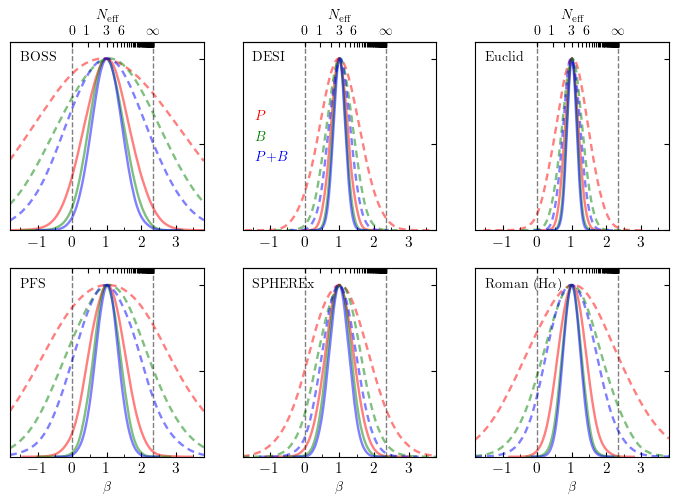

<Figure size 600x450 with 0 Axes>

In [79]:
from getdist import plots, MCSamples
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
reload(df)

nsamp = 10000
random_state = np.random.default_rng(10) # seed random generator
colors = ['red', 'green', 'blue',]
legends = [r'$P$', r'$B$', r'$P$+$B$',]
alphas = [0.5]*6
svys_keys = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'SPHEREx', r'Roman (H$\alpha$)']

fig, axs = plt.subplots(2, 3, figsize=(8.5, 5.5))
g = plots.get_single_plotter()
matplotlib.rcParams['xtick.top'] = False

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:
    for i in range(2):
        for j in range(3):
            ax = axs[i, j]
            svy_key = svys_keys[i*3+j]
            title = svys_title[i*3+j]
            ax.annotate(title, (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
            
            svy.update_survey_setups(survey_geometrics=getattr(dfs, svy_key))
            svy.prepare_alpha_transfer_matrix()
            dadp = svy.alpha_transfer_matrix
            dadp = np.delete(dadp, 5, 1)
            dadp_pi = np.linalg.pinv(dadp)
            s = dadp_pi.T.dot(cmb_fisher.matrix).dot(dadp_pi)
            cp = fm.fisher(s, svy.alpha_transfer_matrix_entries)

            fsp = fm.read_hdf5(f[svy_key]['P']).slice(['alpha', 'beta'], fuzzy_filter=True)
            fsb = fm.read_hdf5(f[svy_key]['B']).slice(['alpha', 'beta'], fuzzy_filter=True)
            samples = []
            fishers = [cp.merge(fsp), cp.merge(fsb), cp.merge(fsp).merge(fsb), fsp, fsb, fsp.merge(fsb)]
            for ma, k in zip(fishers, range(6)):
                print(ma.constraints()[1]['beta'], end=' ')
                cov = np.linalg.inv(ma.matrix)
                ndim = len(cov)
                samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
                names = ma.keys
                labels =  ma.keys
                samples.append(MCSamples(samples=samps,names = names, labels = labels))

            g.plot_1d(samples, 'beta', ax=ax, colors=colors+colors, ls=['-']*3+['--']*3, lims=[-1.8, 3.8],
                      do_xlabel=False, do_ylabel=False,alphas=alphas)
            
            if i==0 and j==1:
                g.settings.figure_legend_frame = False
                g.add_legend(legends, legend_loc='center left', ax=ax, colored_text=True, fontsize=10)

            if i == 1:
                ax.set_xlabel(r'$\beta$')
            ax.xaxis.set_minor_locator(MultipleLocator(0.5))
            

            ax_t = ax.secondary_xaxis("top", functions=(df.b2n, df.n2b))
            ticks = list(range(100))
            tick_lbs = ['0', '1', '', '3', '', '', '6']+['']*92+[r'$\infty$']
            ax_t.set_xticks(ticks)
            if i==0:
                ax_t.set_xticklabels(tick_lbs)
                ax_t.set_xlabel(r'$N_{\rm eff}$')
            if i==1:
                ax_t.set_xticklabels([])
                
            ax.plot([0,0], [0, 1.5], 'k--', lw=1, alpha=.5)
            ax.plot([df.n2b(100),df.n2b(100)], [0, 1.5], 'k--', lw=1, alpha=.5)
            #ax.set_ylim(0, 1)

#fig.savefig('plots/dist-beta.pdf', bbox_inches='tight')
plt.show()

#matplotlib.rcParams['xtick.top'] = True

0.6569880028574532 Removed no burn in
0.4945674343652067 Removed no burn in
0.4374936458551213 Removed no burn in
2.067167051062965 Removed no burn in
1.4652352276807783 Removed no burn in
1.1726436080610536 Removed no burn in
0.24357643416795388 Removed no burn in
0.18588079327841625 Removed no burn in
0.16827872893735876 Removed no burn in
0.5798153770123498 Removed no burn in


<ipython-input-18-0a011e79d013>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
<ipython-input-18-0a011e79d013>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


0.38289210057743595 Removed no burn in
0.309598891619101 Removed no burn in
0.19590110088658025 Removed no burn in
0.1479210234276208 Removed no burn in
0.13493167893696442 Removed no burn in
0.464702693568318 

<ipython-input-18-0a011e79d013>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


Removed no burn in
0.29880485353909153 Removed no burn in
0.24199533073054272 Removed no burn in
0.49590000543653023 Removed no burn in
0.35751702883927133 Removed no burn in
0.31682919616188376 Removed no burn in
1.7157583611991487 Removed no burn in
1.1508967258570773 Removed no burn in


<ipython-input-18-0a011e79d013>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
<ipython-input-18-0a011e79d013>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


0.9266368226128737 Removed no burn in
0.40363170193928843 Removed no burn in
0.3310632659464599 Removed no burn in
0.29443996455988825 Removed no burn in
0.8545816147305678 Removed no burn in
0.604655784243065 Removed no burn in
0.4812099849026367 Removed no burn in
0.3907805849572291 Removed no burn in
0.2787491274936475 Removed no burn in
0.24999564519541015 Removed no burn in
1.3144050318198086 Removed no burn in
0.8376000282497146 Removed no burn in
0.6807039365687021 Removed no burn in


<ipython-input-18-0a011e79d013>:42: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


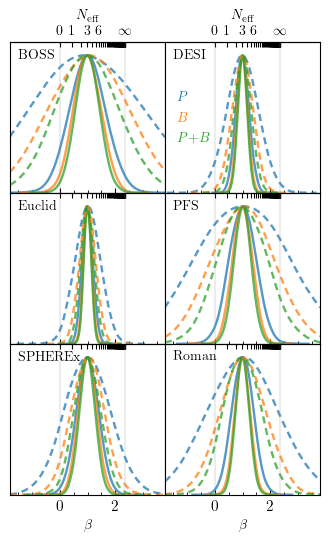

<Figure size 600x450 with 0 Axes>

In [18]:
from getdist import plots, MCSamples
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
reload(df)

nsamp = 10000
random_state = np.random.default_rng(10) # seed random generator
colors = ['C0', 'C1', 'C2',]
legends = [r'$P$', r'$B$', r'$P$+$B$',]
alphas = [0.75]*6
svys_keys = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'SPHEREx', r"Roman"]

fig, axs = plt.subplots(3, 2, figsize=(4, 6))
g = plots.get_single_plotter()
matplotlib.rcParams['xtick.top'] = False

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:
    for i in range(3):
        for j in range(2):
            ax = axs[i, j]
            svy_key = svys_keys[i*2+j]
            title = svys_title[i*2+j]
            ax.annotate(title, (0.05, 0.95), xycoords='axes fraction', ha='left', va='top',)
            
            svy.update_survey_setups(survey_geometrics=getattr(dfs, svy_key))
            svy.prepare_alpha_transfer_matrix()
            dadp = svy.alpha_transfer_matrix
            dadp = np.delete(dadp, 5, 1)
            dadp_pi = np.linalg.pinv(dadp)
            s = dadp_pi.T.dot(cmb_fisher.matrix).dot(dadp_pi)
            cp = fm.fisher(s, svy.alpha_transfer_matrix_entries)

            fsp = fm.read_hdf5(f[svy_key]['P']).slice(['alpha', 'beta'], fuzzy_filter=True)
            fsb = fm.read_hdf5(f[svy_key]['B']).slice(['alpha', 'beta'], fuzzy_filter=True)
            samples = []
            fishers = [cp.merge(fsp), cp.merge(fsb), cp.merge(fsp).merge(fsb), fsp, fsb, fsp.merge(fsb)]
            for ma, k in zip(fishers, range(6)):
                print(ma.constraints()[1]['beta'], end=' ')
                cov = np.linalg.inv(ma.matrix)
                ndim = len(cov)
                samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
                names = ma.keys
                labels =  ma.keys
                samples.append(MCSamples(samples=samps,names = names, labels = labels))

            g.plot_1d(samples, 'beta', ax=ax, colors=colors+colors, ls=['-']*3+['--']*3, lims=[-1.8, 3.8],
                      do_xlabel=False, do_ylabel=False,alphas=alphas)
            
            if i==0 and j==1:
                g.settings.figure_legend_frame = False
                g.add_legend(legends, legend_loc='center left', ax=ax, colored_text=True, fontsize=10)

            if i == 2:
                ax.set_xlabel(r'$\beta$')
            ax.xaxis.set_minor_locator(MultipleLocator(0.5))
            

            ax_t = ax.secondary_xaxis("top", functions=(df.b2n, df.n2b))
            ticks = list(range(100))
            tick_lbs = ['0', '1', '', '3', '', '', '6']+['']*92+[r'$\infty$']
            ax_t.set_xticks(ticks)
            if i==0:
                ax_t.set_xticklabels(tick_lbs)
                ax_t.set_xlabel(r'$N_{\rm eff}$')
            else:
                ax_t.set_xticklabels([])
                
            ax.axvline(0, c='grey', alpha=.15)
            ax.axvline(df.n2b(100), c='grey', alpha=.15)
            #ax.set_ylim(0, 1)
            ax.set_yticks([])

fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('plots/dist-beta.pdf', bbox_inches='tight')
plt.show()

#matplotlib.rcParams['xtick.top'] = True

In [15]:
# default result
# Pw, Bw, Pw+Bw (phase shift only)
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5').slice(
    ['ombh2', 'omch2', 'As', 'ns', 'tau', 'thetastar', 'nnu'])

polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]

polys_ex_w = ['poly', 'bias']

with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman', 'cvl']:
        svy.update_survey_setups(survey_geometrics=getattr(dfs, svy_key))
        svy.prepare_alpha_transfer_matrix()
        dadp = svy.alpha_transfer_matrix
        dadp = np.delete(dadp, 5, 1)
        dadp_pi = np.linalg.pinv(dadp)
        s = dadp_pi.T.dot(cmb_fisher.matrix).dot(dadp_pi)
        cp = fm.fisher(s, svy.alpha_transfer_matrix_entries)
            
            
        group_svy = f[svy_key]
        print(getattr(dfs, svy_key)['name'], end=' ')
        fsp = fm.read_hdf5(f[svy_key]['P']).slice(['alpha', 'beta'], fuzzy_filter=True)
        fsb = fm.read_hdf5(f[svy_key]['B']).slice(['alpha', 'beta'], fuzzy_filter=True)

        for fs in [fsp, fsb, fsp.merge(fsb), fsp.merge(cp), fsb.merge(cp), fsp.merge(fsb).merge(cp)]:
            sb = fs.constraints()[1]['beta']
            sn = df.sb2sn(sb)
            print('& %.3f'%sn, end=' ')
        print('\\\\')

BOSS & 10.652 & 7.551 & 6.043 & 3.385 & 2.548 & 2.254 \\
DESI & 2.988 & 1.973 & 1.595 & 1.255 & 0.958 & 0.867 \\
Euclid & 2.395 & 1.540 & 1.247 & 1.009 & 0.762 & 0.695 \\
PFS & 8.842 & 5.931 & 4.775 & 2.645 & 1.893 & 1.554 \\
SPHEREx & 4.404 & 3.116 & 2.480 & 2.080 & 1.706 & 1.517 \\
Roman (H$\alpha$) & 6.773 & 4.316 & 3.508 & 2.014 & 1.436 & 1.288 \\
CVL & 0.959 & 0.585 & 0.472 & 0.387 & 0.270 & 0.233 \\


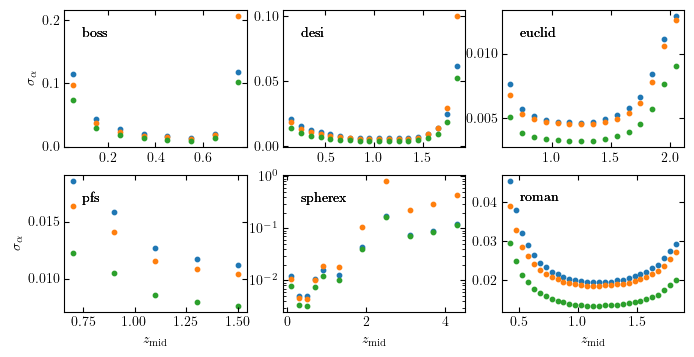

In [52]:
reload(fm)

fig, axs = plt.subplots(2, 3, figsize=(8, 4))

with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    i = 0
    for svy_key in ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman',]:
        group_svy = f[svy_key]
        fsp = fm.read_hdf5(f[svy_key]['Pw']).slice(['alpha',], fuzzy_filter=True)
        fsb = fm.read_hdf5(f[svy_key]['Bw']).slice(['alpha',], fuzzy_filter=True)
        ax = axs[i//3, i%3]
        for fs in [fsp, fsb, fsp.merge(fsb)]:
            zmids = [(float(x[10:14])+float(x[19:]))/2 for x in fs.keys]
            sas = fs.constraints()[0]
            #print(svy_key, fs.keys)
            ax.scatter(zmids, sas, s=10)
            if i==4:
                ax.set_yscale('log')
            ax.annotate(svy_key, (0.1, 0.8), xycoords='axes fraction' )
            if i%3==0:
                ax.set_ylabel(r'$\sigma_\alpha$')
            if i//3==1:
                ax.set_xlabel(r'$z_{\rm mid}$')
        i += 1

In [58]:
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    i = 0
    for svy_key in ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman', 'cvl']:
        group_svy = f[svy_key]
        fsp = fm.read_hdf5(f[svy_key]['Pw']).slice(['alpha',], fuzzy_filter=True)
        fsb = fm.read_hdf5(f[svy_key]['Bw']).slice(['alpha',], fuzzy_filter=True)
        print(svy_key, end='\t')
        for fs in [fsp, fsb, fsp.merge(fsb)]:
            print('%.4f\t'%(1/np.sqrt(np.sum(np.diag(fs.matrix)))), end='')
        print('')
        i += 1

boss	0.0079	0.0069	0.0052	
desi	0.0020	0.0018	0.0013	
euclid	0.0015	0.0014	0.0010	
pfs	0.0059	0.0054	0.0040	
spherex	0.0031	0.0028	0.0021	
roman	0.0042	0.0039	0.0029	
cvl	0.0004	0.0005	0.0003	


In [19]:
import h5py
import fisher_matrix as fm
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    i = 0
    for svy_key, sv in zip(['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman', 'cvl'],
                           ['BOSS', 'DESI', 'Euclid', 'PFS', 'SPHEREx', r'Roman (H$\alpha$)', 'CVL']
                          ):
        group_svy = f[svy_key]
        fsp = fm.read_hdf5(f[svy_key]['Pw']).slice(['alpha',], fuzzy_filter=True)
        fsb = fm.read_hdf5(f[svy_key]['Bw']).slice(['alpha',], fuzzy_filter=True)
        print(sv, end='\t')
        for fs in [fsp, fsb, fsp.merge(fsb)]:
            print('& %.4f '%(1/np.sqrt(np.sum(np.diag(fs.matrix)))), end='')
        print('\\\\')
        i += 1

BOSS	& 0.0079 & 0.0069 & 0.0052 \\
DESI	& 0.0020 & 0.0018 & 0.0013 \\
Euclid	& 0.0015 & 0.0014 & 0.0010 \\
PFS	& 0.0059 & 0.0054 & 0.0040 \\
SPHEREx	& 0.0031 & 0.0028 & 0.0021 \\
Roman (H$\alpha$)	& 0.0042 & 0.0039 & 0.0029 \\
CVL	& 0.0004 & 0.0005 & 0.0003 \\


Removed no burn in
Removed no burn in
Removed no burn in


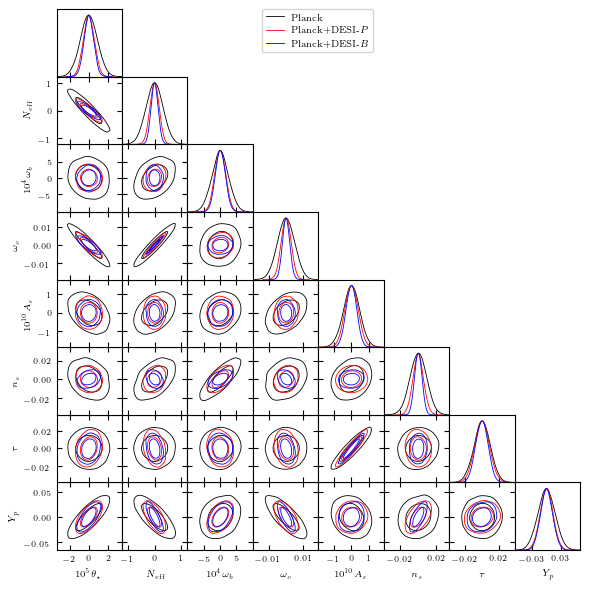

Removed no burn in
Removed no burn in
Removed no burn in


C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:139: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([0]*ndim, cc, size=nsamp)


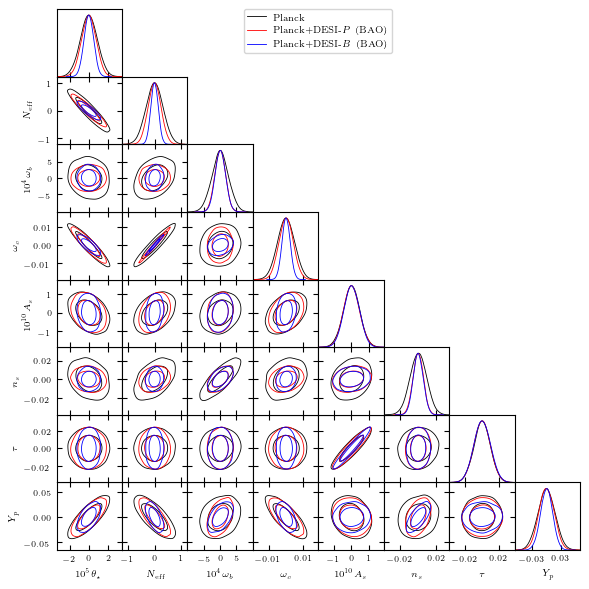

Removed no burn in
Removed no burn in
Removed no burn in


C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:139: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([0]*ndim, cc, size=nsamp)


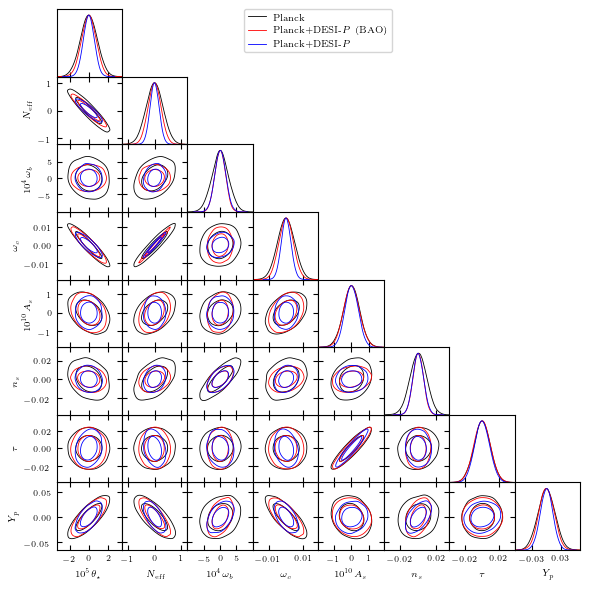

In [68]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:
    fsb = fm.read_hdf5(f['desi']['B']).slice(['alpha', 'beta'], exclude=True)
    fsbw = fm.read_hdf5(f['desi']['Bw']).slice(['alpha', 'beta'], exclude=True)
    fsp = fm.read_hdf5(f['desi']['P']).slice(['alpha', 'beta'], exclude=True)
    fspw = fm.read_hdf5(f['desi']['Pw']).slice(['alpha', 'beta'], exclude=True)
    
    keys = ['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']
    labels =  [r'$10^5\theta_\star$', r'$ N_{\rm eff}$', r'$10^4\omega_b$', r'$\omega_c$', 
           r'$ 10^{10}A_s$', r'$ n_s$', r'$\tau$', r'$ Y_p$']
    norms = {'thetastar': 1e5,'ombh2': 1e4,'As': 1e10,}
    
    #
    fm.triangle_plot([cmb_fisher, fsp.merge(cmb_fisher), fsb.merge(cmb_fisher), ], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$', 'Planck+DESI-$B$', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
    plt.savefig('fisher-matrix-broadband-corner.pdf', bbox_inches='tight')
    plt.show()
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsbw)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$B$ (BAO)', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
    plt.savefig('fisher-matrix-wiggle-corner.pdf', bbox_inches='tight')
    plt.show()
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsp)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$P$', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
#     plt.savefig('fisher-matrix-wiggle-corner.pdf', bbox_inches='tight')
    plt.show()

Removed no burn in
Removed no burn in
Removed no burn in


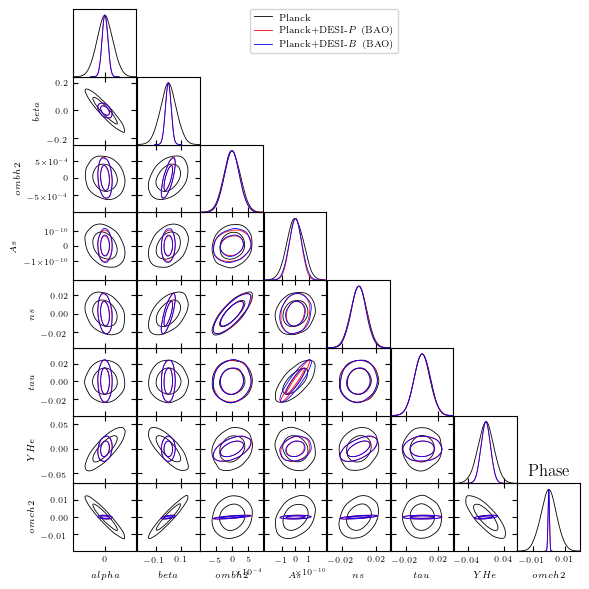

Removed no burn in
Removed no burn in
Removed no burn in


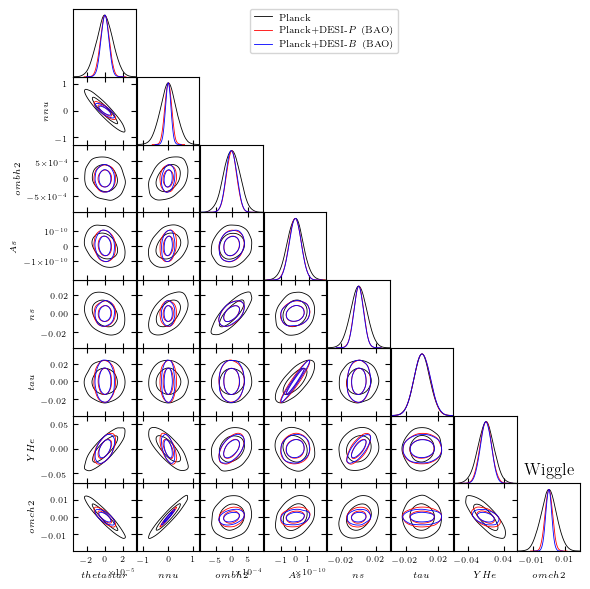

In [92]:
reload(fm)
keys = ['alpha', 'beta', 'ombh2', 'As', 'ns', 'tau', 'YHe', 'omch2']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher.hdf5').slice(keys)

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:    
    fsbw = fm.read_hdf5(f['desi']['Bw']).slice(keys)
    fspw = fm.read_hdf5(f['desi']['Pw']).slice(keys)
    labels =  keys
    norms = {}
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsbw)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$B$ (BAO)', ], 
                 parameter_labels=labels, norms=norms)
    plt.title('Phase')
    plt.show()
    
    
reload(fm)
keys = ['thetastar', 'nnu', 'ombh2', 'As', 'ns', 'tau', 'YHe', 'omch2']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5').slice(keys)

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:
    fsbw = fm.read_hdf5(f['desi']['Bw']).slice(keys)
    fspw = fm.read_hdf5(f['desi']['Pw']).slice(keys)
    labels =  keys
    norms = {}
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsbw)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$B$ (BAO)', ], 
                 parameter_labels=labels, norms=norms)
    plt.title('Wiggle')
    plt.show()

['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']


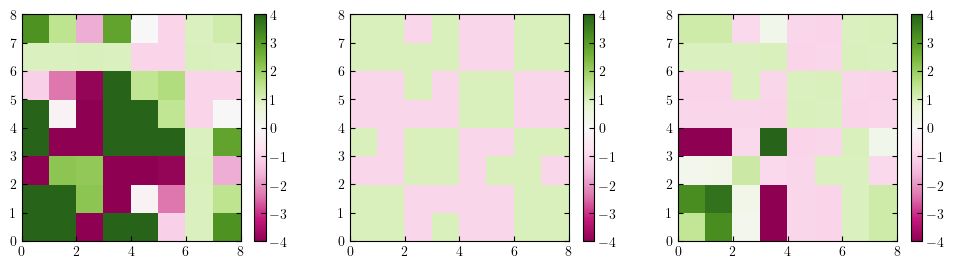

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
i = 0
print(keys)
for fs in [cmb_fisher.merge(fsb), cmb_fisher, cmb_fisher.merge(fsbw)]:
    matrix0 = cmb_fisher.slice(keys).matrix
    z = fs.slice(keys).matrix/np.abs(matrix0)
    ax = axs[i]
    c = ax.pcolormesh(z, vmax=4, vmin=-4, cmap='PiYG')
    fig.colorbar(c, ax=ax)
    i += 1

### Kmax dependence

In [63]:
surveys = [dfs.boss, dfs.desi, dfs.euclid, dfs.pfs, dfs.spherex, dfs.roman, ]
ks = np.linspace(0.02, 0.3, num=29)

In [7]:
with h5py.File("survey_fisher_matrix_kmax_poly.hdf5", "w") as f:
    for survey in surveys:
        svy.update_survey_setups(survey_geometrics=survey)
        key_svy = survey['short_name']
        print(key_svy, end='\t')
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
            group_svy.attrs['zmax'] = svy.z_max
        else:
            group_svy = f[key_svy]
        for i in tqdm(range(len(ks))):
            kmax = ks[i]
            key_k = '%d'%i
            if key_k not in list(group_svy.keys()):
                group_k = group_svy.create_group(key_k)
                group_k.attrs['kmax'] = kmax
            else:
                group_k = group_svy[key_k]
            
            for x, l in zip([True, False], ['w', '']):
                fsp = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, div_k = int((kmax-0.01)/0.0025),
                            regions=[{'k_min': 0.01,'k_max': kmax,'mu_min': -1.0,'mu_max': 1.0}])
                div = int(max(6, (kmax)/0.045))
                print(div, end='')
                fsb = svy.get_bispectrum_fisher_matrix(wiggle_only=x,
                            direct_poly_derivative=True,
                            regions = [{'coordinate': 'cartesian',\
                                            'mu_opt': True,\
                                            'bounds': ((0.01, kmax),(0.01, kmax),(0.01, kmax),(0, 1),(0, 6.283185307179586)),\
                                            'divideby': 'num',\
                                            'divs': (div, div, div, div, div)}], verbose=True)

                key_fs = 'P'+l
                if key_fs not in list(group_k.keys()):
                    group_fs = group_k.create_group(key_fs)
                fsp.write_hdf5(group_fs)

                key_fs = 'B'+l
                if key_fs not in list(group_k.keys()):
                    group_fs = group_k.create_group(key_fs)
                fsb.write_hdf5(group_fs)
                print('+'+l, end='')

boss	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+desi	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+pfs	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+roman	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>

In [12]:
def reshape_lines(s):
    for i in range(len(s)-1):
        k = len(s)-i-1
        if s[k-1]<s[k]:
            s[k-1] = s[k]
        if s[k-1]>cmb_fisher.constraints()[1]['nnu']:
            s[k-1] = cmb_fisher.constraints()[1]['nnu']
    return s

boss boss boss 

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss [0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15
 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29
 0.3 ] [0.31674182 0.31674182 0.31670361 0.31663946 0.31660376 0.31649928
 0.31642306 0.31628131 0.31605908 0.31547539 0.31515124 0.3149193
 0.31329691 0.3059121  0.30387505 0.30325736 0.30112737 0.29965884
 0.29931922 0.29800939 0.29626329 0.29614595 0.29578122 0.29481474
 0.29468305 0.29436944 0.29415236 0.29401791 0.29375001]
desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi [0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15
 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29
 0.3 ] [0.31674264 0.31651056 0.31549858 0.31467562 0.31335539 0.31007272
 0.30818976 0.30511507 0.30205932 0.

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman [0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15
 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29
 0.3 ] [0.31674264 0.31670048 0.31658109 0.31634793 0.31605811 0.31518735
 0.31466998 0.31366991 0.31263513 0.31181017 0.31051951 0.30936111
 0.30808795 0.30267432 0.30059392 0.29931422 0.29708108 0.29592357
 0.29510728 0.29311559 0.29123476 0.29064523 0.28978254 0.28815877
 0.28762989 0.28676804 0.28619584 0.28541762 0.28470638]
boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi euclid euclid euclid euclid euclid euclid euclid euclid euclid eucli

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex roman 

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman 

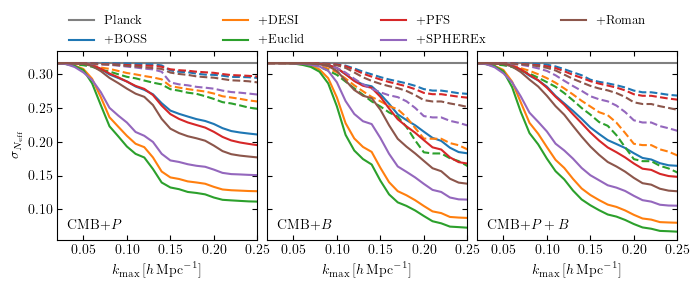

In [173]:
reload(fm)
reload(df)
dfs = df.defaults()

fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.07)
surveys = [dfs.boss, dfs.desi, dfs.euclid, dfs.pfs, dfs.spherex, dfs.roman, ]
#surveys = [dfs.boss]
cmb_survey = 'planck'
#cmb_survey = 'cmb_s3'
#cmb_survey = 'cmb_s4'
cmb_fisher = fm.read_hdf5('%s_cmb_fisher_original.hdf5'%cmb_survey)

cps_ex = ['alpha', 'beta',]



polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]

# polys_ex = ['poly', 'bias']
# polys_ex_w = ['poly', 'bias']

if cmb_survey == 'planck':
    cmb_label = 'Planck'
    ymin, ymax = 0.055, 0.335
if cmb_survey == 'cmb_s3':
    cmb_label = 'CMB-S3'
    ymin, ymax = 0.03, 0.125
    
if cmb_survey == 'cmb_s4':
    cmb_label = 'CMB-S4'
    ymin, ymax = 0.025, 0.087

ax = axs[0]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), label=cmb_label, c='grey')

with h5py.File("survey_fisher_matrix_kmax_poly.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsp, fspw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['boss', 'desi']:
            label = '+'+survey['name']
        else:
            label = None
            label = '+'+survey['name']
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls='--')
        print(ks, sns[:,1])
ax.legend(bbox_to_anchor=(0., 1.15, 3, .1), loc='upper right', mode='expand', ncol=4, prop={'size': 9}, frameon=False)
ax.annotate(r'CMB+$P$', (0.05, 0.05), xycoords='axes fraction')
ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)

ax = axs[1]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), c='grey')

with h5py.File("survey_fisher_matrix_kmax_poly.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsb, fsbw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['euclid', 'pfs']:
            label = '+'+survey['name']
        else:
            label = None
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls='--')
#ax.legend()
ax.annotate(r'CMB+$B$', (0.05, 0.05), xycoords='axes fraction')
#ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)

ax = axs[2]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), c='grey')

with h5py.File("survey_fisher_matrix_kmax_poly.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsp.merge(fsb), fspw.merge(fsbw)]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['roman', 'spherex']:
            label = '+'+survey['name']
        else:
            label = None
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls='--')
#ax.legend()
ax.annotate(r'CMB+$P+B$', (0.05, 0.05), xycoords='axes fraction')
#ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)

fig.subplots_adjust(wspace=0.05, hspace=0)
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

for ax in axs:
    ax.set_xlim(None, .25)
    ax.set_xticks([.05, .1, .15, .2, .25])


plt.savefig('plots/kmax_dependence-%s.pdf'%cmb_survey, bbox_inches='tight')
plt.show()

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

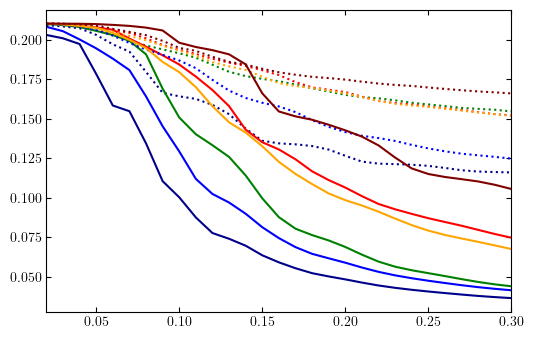

In [32]:
poly_exs = [
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b3', 'b4', 'b5'],
    ['b2', 'b3', 'b4', 'b5'],
    ['a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a3', 'a4', 'b2', 'b3', 'b4', 'b5'],
    [],
]
cps_ex = ['alpha', 'beta', 'YHe', 'tau']
cs = ['darkblue', 'green', 'red', 'blue', 'orange', 'maroon']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')


with h5py.File("survey_fisher_matrix_kmax_poly.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    poly_ex = ['poly_'+x for x in poly_ex]
    for poly_ex, c in zip(poly_exs, cs):
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            for fs in [fsp, fspw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        pl = plt.plot(ks, reshape_lines(sns[:,0]), c=c)
        plt.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
#ax.legend()

euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid

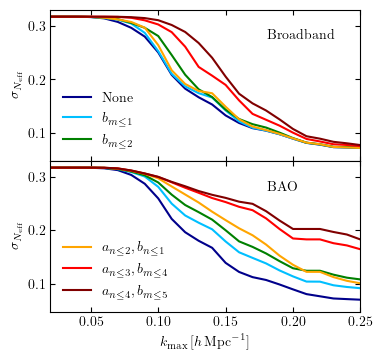

In [182]:
poly_exs = [
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a0', 'a1', 'a2', 'a3', 'a4',       'b2', 'b3', 'b4', 'b5'],
    ['a0', 'a1', 'a2', 'a3', 'a4',             'b3', 'b4', 'b5'],
    [                  'a3', 'a4',       'b2', 'b3', 'b4', 'b5'],
    [                        'a4',                         'b5'],
    [],
]

# polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
# polys_ex_w = ['a4', 'b5']

poly_lbs = ['None', '$b_{m\le1}$', '$b_{m\le2}$', 
            '$a_{n\le2},b_{n\le1}$', '$a_{n\le3},b_{m\le4}$', '$a_{n\le4},b_{m\le5}$']
cps_ex = ['alpha', 'beta', ]
cs = ['darkblue', 'deepskyblue', 'green', 'orange', 'red', 'maroon']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')

fig, axs = plt.subplots(2, 1, figsize=(4, 4))

with h5py.File("survey_fisher_matrix_kmax_poly.hdf5", "r") as f:
    survey = dfs.euclid
    key_svy = survey['short_name']
    j = 0
    for poly_ex, c, lb in zip(poly_exs, cs, poly_lbs):
        sns = []
        poly_ex = ['poly_'+x for x in poly_ex]
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            for fs in [fsb, fsbw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True, fuzzy_filter=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if j<3:
            xlb = lb
        else:
            xlb = None
        pl = axs[0].plot(ks, reshape_lines(sns[:,0]), c=c, label=xlb)
        if j>=3:
            xlb = lb
        else:
            xlb = None
        axs[1].plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), label=xlb)
        j += 1
axs[0].legend(frameon=False, loc='lower left')
axs[1].legend(frameon=False, loc='lower left')
axs[0].annotate('Broadband', (0.7, 0.8), xycoords='axes fraction')
axs[1].annotate('BAO', (0.7, 0.8), xycoords='axes fraction')
axs[0].set_xticklabels([])
for ax in axs:
    ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
    ax.set_xlim(None, 0.25)
    ax.set_ylim(None, 0.33)
axs[1].set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('plots/bispectrum-polynomials.pdf', bbox_inches='tight')

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

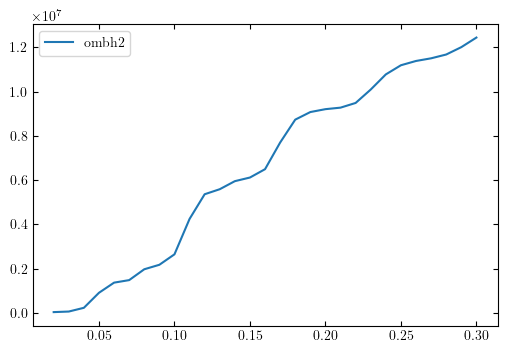

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

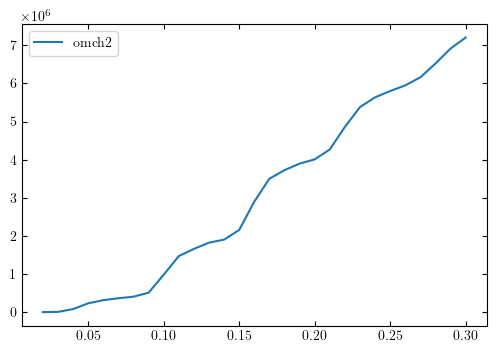

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

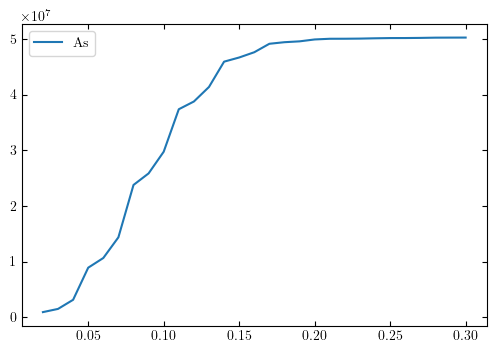

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

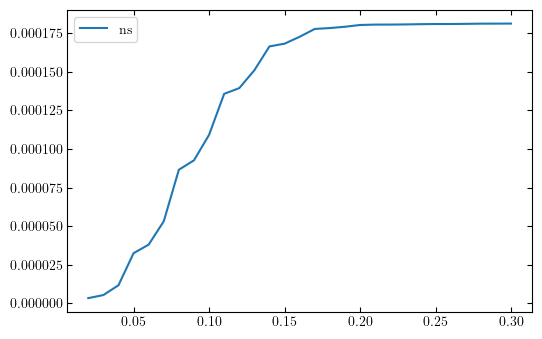

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

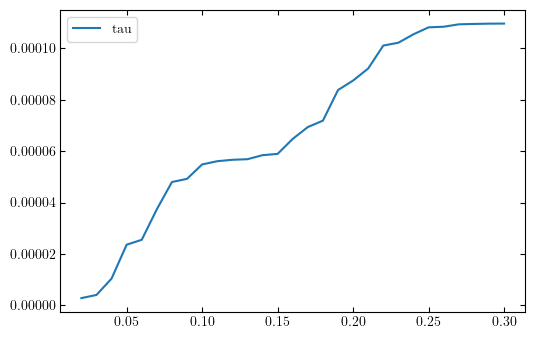

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

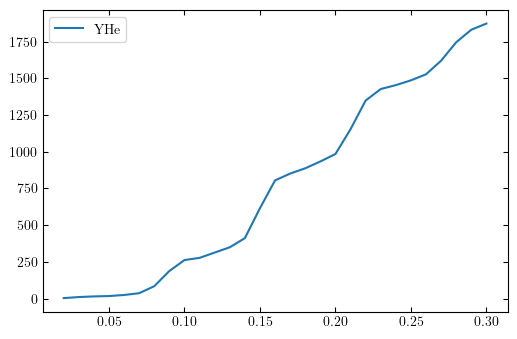

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

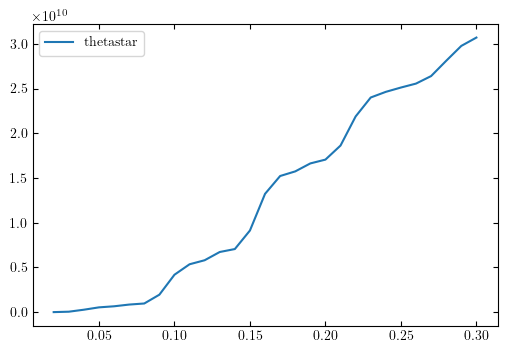

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

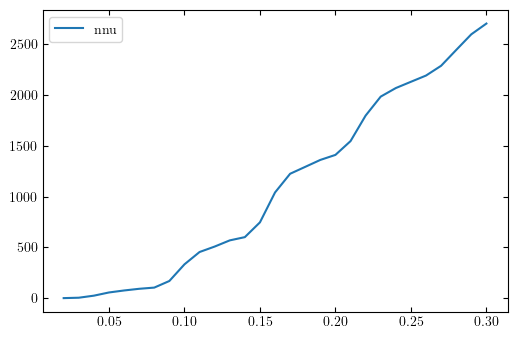

In [41]:
with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    for el in svy.cosmological_parameters_in_fisher:
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['P'])
            fspw = fm.read_hdf5(fv[key_k]['Pw'])
            for fs in [fsp, fspw]:
                sn = fs.element(el)
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        #plt.plot(ks, sns[:,0], label=el)
        plt.plot(ks, sns[:,1], label=el)
        plt.legend()
        plt.show()

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

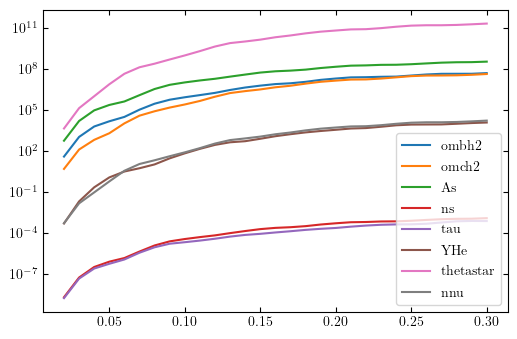

In [36]:
with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    for el in svy.cosmological_parameters_in_fisher:
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['B'])
            fspw = fm.read_hdf5(fv[key_k]['Bw'])
            for fs in [fsp, fspw]:
                sn = fs.element(el)
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        plt.semilogy(ks, sns[:,1], label=el)
plt.legend()